<p style="background-color:#808080;"><span style="color:#ffffff;"><i> 
<img src="https://www.kitepackaging.co.uk/images/kite-logo-2021.png" alt="Logo" width="100" height="200">

>>>>#                            **KITE PACKAGING : ROUTE OPTIMISER - 50 Miles**

#

<div style="text-align: center;">
    <img src="https://media.kitepackaging.co.uk/images/content/kite-fleet-6df6ac59-afec-490a-b826-5ccf19a1d715..png?width=2400&optimize=medium" alt="Logo" width="800" height="700">
</div>
'''

<p style="background-color:#808080;"><span style="color:#ffffff;"><i> 
<img src="https://www.kitepackaging.co.uk/images/kite-logo-2021.png" alt="Logo" width="100" height="200">

## Step 1) Set-Up the Environment

In [65]:
!pip install pandas googlemaps ortools


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


#####

In [67]:
# Install googlemaps library.
!pip install googlemaps


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [68]:
# Install geopy library.
!pip install pandas geopy ortools scipy


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [69]:
# Import libraries.
import googlemaps
import pandas as pd
import requests
from geopy.distance import geodesic
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import numpy as np
import datetime
import time
from datetime import datetime, timedelta
import os
import requests
from dotenv import load_dotenv

# Install dot env
!pip install python-dotenv


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# locate and read the key from the dotenv file

# Load the .env file
load_dotenv()

API_key = os.getenv('GMaps_API_Key')


<p style="background-color:#808080;"><span style="color:#ffffff;"><i> 
<img src="https://www.kitepackaging.co.uk/images/kite-logo-2021.png" alt="Logo" width="100" height="200">

## Step 2) Retrieve Distance and Duration Data Using Google Maps Directions API

### Considerations:

- Each stop includes a 8-minute delivery time.
- Set maximum limit of no of stops per route = between 20 - 23 stops (check output, aim to keep no of routes per day to a minumum, but be wary of driver duration time going over 8 hours)
- No of stops divided evenly by route if more than 20-23 orders per day
- Deliveries are only done Monday through Friday.
- Customer locations extracted from CSV containing columns 'Latitude' / 'Longitude'
- **Filtered by order cluster =1**
- **Filtered by area cluster =1**
- **Filtered by date (only Monday - Friday)**

Desired outputs:
dataframe showing by date / weekday:
- no of routes
- total cubic_m3, pallet space, payload
- total revenue
- total delivery cost (courier)
  

>### 1 - with cluster by order filtering (=1) and cluster by area filtering (=0) dividing orders evenly by route
>#### Route summary 6 and 13

In [75]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import os

API_key = os.getenv('GMaps_API_Key')

# Warehouse coordinates (starting and ending point)
warehouse_coords = "52.378855,-1.493756"
origin = warehouse_coords
destination = warehouse_coords

# Load customer locations from CSV
customer_data = pd.read_csv('df_cost_clustering.csv')
customer_data['date_despatched'] = pd.to_datetime(customer_data['date_despatched'])

desired_order_cluster = 1
desired_area_cluster = 0
max_orders_per_route = 23
delivery_time_per_stop = timedelta(minutes=8)
filtered_data = customer_data[(customer_data['orders_cluster'] == desired_order_cluster) &
                              (customer_data['cluster_area'] == desired_area_cluster)]
filtered_data = filtered_data.sort_values(by='date_despatched')
filtered_data = filtered_data[filtered_data['date_despatched'].dt.weekday < 5]

route_summary_list = []
route_details_by_id = {}
cumulative_route_id = 1

# Specific routes for detailed stop-to-stop analysis
selected_route_ids = [6, 13]

for route_date in filtered_data['date_despatched'].unique():
    daily_data = filtered_data[filtered_data['date_despatched'] == route_date]
    total_orders = len(daily_data)
    num_routes = (total_orders + max_orders_per_route - 1) // max_orders_per_route
    orders_per_route = total_orders // num_routes
    extra_orders = total_orders % num_routes
    daily_routes = []
    start_index = 0
    for i in range(num_routes):
        route_size = orders_per_route + (1 if i < extra_orders else 0)
        daily_routes.append(daily_data.iloc[start_index: start_index + route_size])
        start_index += route_size

    for daily_route_id, route_data in enumerate(daily_routes, start=1):
        locations = [warehouse_coords] + route_data.apply(lambda row: f"{row['latitude']},{row['longitude']}", axis=1).tolist()
        waypoints = "|".join(locations[1:])
        
        # Initial API request for optimized route
        url = f"https://maps.googleapis.com/maps/api/directions/json?origin={origin}&destination={destination}&waypoints=optimize:true|{waypoints}&key={API_key}"
        response = requests.get(url)
        data = response.json()

        if data['status'] == 'OK':
            waypoint_order = data['routes'][0]['waypoint_order']
            
            # Reorder route_data based on optimized waypoint order
            optimized_stops = [warehouse_coords] + [locations[1:][i] for i in waypoint_order] + [warehouse_coords]

            total_distance = 0
            total_drive_duration = timedelta(0)
            route_detail_data = []

            arrival_time = datetime.combine(route_date, datetime.min.time()) + timedelta(hours=7, minutes=30)
            last_arrival_time = arrival_time

            route_detail_data.append({
                'Stop Number': 'Warehouse (Start)',
                'Order ID': '',
                'Latitude': warehouse_coords.split(',')[0],
                'Longitude': warehouse_coords.split(',')[1],
                'Postcode': 'CV3 4GB',
                'Arrival Time': arrival_time.strftime('%H:%M'),
                'Distance (km)': 0,
                'Travel Duration (mins)': 0,
                'Stop Duration (mins)': 0,
                'Total Duration (mins)': 0
            })

            # Make individual API requests for each stop-to-stop distance in optimized order
            for i in range(len(optimized_stops) - 1):
                origin_stop = optimized_stops[i]
                destination_stop = optimized_stops[i + 1]
                
                # Request each stop-to-stop distance
                stop_to_stop_url = f"https://maps.googleapis.com/maps/api/directions/json?origin={origin_stop}&destination={destination_stop}&key={API_key}"
                stop_response = requests.get(stop_to_stop_url)
                stop_data = stop_response.json()

                if stop_data['status'] == 'OK' and stop_data['routes']:
                    leg = stop_data['routes'][0]['legs'][0]
                    distance_km = leg['distance']['value'] / 1000
                    travel_duration_mins = leg['duration']['value'] / 60
                    
                    # Add up total distance and driving duration
                    total_distance += distance_km
                    total_drive_duration += timedelta(minutes=travel_duration_mins)
                    
                    arrival_time = last_arrival_time + timedelta(minutes=travel_duration_mins)
                    last_arrival_time = arrival_time
                    
                    stop_duration = 8  # Set a standard stop duration of 8 minutes
                    
                    # Fetch Order ID and postcode for each waypoint
                    if i < len(route_data):
                        order_row = route_data.iloc[waypoint_order[i]]
                        order_id = order_row['order_id']
                        postcode = order_row['delivery_postcode']
                    else:
                        order_id = ''
                        postcode = 'CV3 4GB'
                    
                    route_detail_data.append({
                        'Stop Number': i + 1,
                        'Order ID': order_id,
                        'Latitude': destination_stop.split(',')[0],
                        'Longitude': destination_stop.split(',')[1],
                        'Postcode': postcode,
                        'Arrival Time': arrival_time.strftime('%H:%M'),
                        'Distance (km)': round(distance_km, 2),
                        'Travel Duration (mins)': round(travel_duration_mins, 2),
                        'Stop Duration (mins)': stop_duration,
                        'Total Duration (mins)': round(travel_duration_mins + stop_duration, 2)
                    })

            route_detail_data.append({
                'Stop Number': 'Warehouse (End)',
                'Order ID': '',
                'Latitude': warehouse_coords.split(',')[0],
                'Longitude': warehouse_coords.split(',')[1],
                'Postcode': 'CV3 4GB',
                'Arrival Time': arrival_time.strftime('%H:%M'),
                'Distance (km)': 0,
                'Travel Duration (mins)': 0,
                'Stop Duration (mins)': 0,
                'Total Duration (mins)': 0
            })

            total_travel_duration = sum([x['Travel Duration (mins)'] for x in route_detail_data[1:]])
            total_stop_duration = sum([x['Stop Duration (mins)'] for x in route_detail_data[1:]])
            total_duration = total_travel_duration + total_stop_duration
            total_duration_hours = total_duration / 60
            
            route_detail_data.append({
                'Stop Number': 'Totals',
                'Order ID': '',
                'Latitude': '',
                'Longitude': '',
                'Postcode': '',
                'Arrival Time': '',
                'Distance (km)': '',
                'Travel Duration (mins)': total_travel_duration,
                'Stop Duration (mins)': total_stop_duration,
                'Total Duration (mins)': total_duration
            })
            
            route_detail_data.append({
                'Stop Number': 'Total Duration (hrs)',
                'Order ID': '',
                'Latitude': '',
                'Longitude': '',
                'Postcode': '',
                'Arrival Time': '',
                'Distance (km)': '',
                'Travel Duration (mins)': '',
                'Stop Duration (mins)': '',
                'Total Duration (mins)': total_duration_hours
            })

            total_cubic_m = route_data['total_cubic_m'].sum()
            pallet_space = route_data['pallet_space'].sum()
            line_weight_recalc = route_data['line_weight_recalc'].sum()
            delivery_cost = route_data['delivery_cost'].sum()
            total_price = route_data['total_price'].sum()
            order_count = len(route_data)
            
            delivery_cost_percentage = (delivery_cost / total_price) * 100 if total_price > 0 else 0

            route_summary = {
                'route_id': cumulative_route_id,
                'date_despatched': route_date.date(),
                'daily_route_num': daily_route_id,
                'cumulative_route_id': cumulative_route_id,
                'total_routes_for_day': num_routes,
                'order_count': order_count,
                'total_cubic_m': total_cubic_m,
                'pallet_space': pallet_space,
                'line_weight_recalc': line_weight_recalc,
                'delivery_cost': delivery_cost,
                'total_price': total_price,
                'total_distance_km': total_distance,
                'total_duration_hr': round(total_duration / 60, 2),
                'delivery_cost_percentage': round(delivery_cost_percentage, 2)
            }

            route_summary_list.append(route_summary)
            
            if cumulative_route_id in selected_route_ids:
                route_details_by_id[cumulative_route_id] = pd.DataFrame(route_detail_data)
            
            cumulative_route_id += 1

# Save summary and detailed data for selected routes to Excel
route_summary_df = pd.DataFrame(route_summary_list).sort_values(by='date_despatched')
excel_filename = f"50m_route_summary_cluster{desired_order_cluster}_area{desired_area_cluster}_max{max_orders_per_route}_Selected_Routes.xlsx"

with pd.ExcelWriter(excel_filename) as writer:
    route_summary_df.to_excel(writer, sheet_name='Route Summary', index=False)
    for route_id, route_details_df in route_details_by_id.items():
        route_details_df.to_excel(writer, sheet_name=f"Route {route_id}", index=False)

# Export Route Summary to CSV for cost prediction
csv_filename = f"50m_route_summary_cluster{desired_order_cluster}_area{desired_area_cluster}_max{max_orders_per_route}_Summary.csv"
route_summary_df.to_csv(csv_filename, index=False)

print(f"50m_Route details have been exported to '{excel_filename}' and summary to CSV '{csv_filename}'")

50m_Route details have been exported to '50m_route_summary_cluster1_area0_max23_Selected_Routes.xlsx' and summary to CSV '50m_route_summary_cluster1_area0_max23_Summary.csv'


>### 2 - with cluster by order filtering (=1) and cluster by area filtering (=1) dividing orders evenly by route
>>#### Route summary 9 and 23

In [77]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import os

API_key = os.getenv('GMaps_API_Key')

# Warehouse coordinates (starting and ending point)
warehouse_coords = "52.378855,-1.493756"
origin = warehouse_coords
destination = warehouse_coords

# Load customer locations from CSV
customer_data = pd.read_csv('df_cost_clustering.csv')
customer_data['date_despatched'] = pd.to_datetime(customer_data['date_despatched'])

desired_order_cluster = 1
desired_area_cluster = 1
max_orders_per_route = 20
delivery_time_per_stop = timedelta(minutes=8)
filtered_data = customer_data[(customer_data['orders_cluster'] == desired_order_cluster) &
                              (customer_data['cluster_area'] == desired_area_cluster)]
filtered_data = filtered_data.sort_values(by='date_despatched')
filtered_data = filtered_data[filtered_data['date_despatched'].dt.weekday < 5]

route_summary_list = []
route_details_by_id = {}
cumulative_route_id = 1

# Specific routes for detailed stop-to-stop analysis
selected_route_ids = [9, 23]

for route_date in filtered_data['date_despatched'].unique():
    daily_data = filtered_data[filtered_data['date_despatched'] == route_date]
    total_orders = len(daily_data)
    num_routes = (total_orders + max_orders_per_route - 1) // max_orders_per_route
    orders_per_route = total_orders // num_routes
    extra_orders = total_orders % num_routes
    daily_routes = []
    start_index = 0
    for i in range(num_routes):
        route_size = orders_per_route + (1 if i < extra_orders else 0)
        daily_routes.append(daily_data.iloc[start_index: start_index + route_size])
        start_index += route_size

    for daily_route_id, route_data in enumerate(daily_routes, start=1):
        locations = [warehouse_coords] + route_data.apply(lambda row: f"{row['latitude']},{row['longitude']}", axis=1).tolist()
        waypoints = "|".join(locations[1:])
        
        # Initial API request for optimized route
        url = f"https://maps.googleapis.com/maps/api/directions/json?origin={origin}&destination={destination}&waypoints=optimize:true|{waypoints}&key={API_key}"
        response = requests.get(url)
        data = response.json()

        if data['status'] == 'OK':
            waypoint_order = data['routes'][0]['waypoint_order']
            
            # Reorder route_data based on optimized waypoint order
            optimized_stops = [warehouse_coords] + [locations[1:][i] for i in waypoint_order] + [warehouse_coords]

            total_distance = 0
            total_drive_duration = timedelta(0)
            route_detail_data = []

            arrival_time = datetime.combine(route_date, datetime.min.time()) + timedelta(hours=7, minutes=30)
            last_arrival_time = arrival_time

            route_detail_data.append({
                'Stop Number': 'Warehouse (Start)',
                'Order ID': '',
                'Latitude': warehouse_coords.split(',')[0],
                'Longitude': warehouse_coords.split(',')[1],
                'Postcode': 'CV3 4GB',
                'Arrival Time': arrival_time.strftime('%H:%M'),
                'Distance (km)': 0,
                'Travel Duration (mins)': 0,
                'Stop Duration (mins)': 0,
                'Total Duration (mins)': 0
            })

            # Make individual API requests for each stop-to-stop distance in optimized order
            for i in range(len(optimized_stops) - 1):
                origin_stop = optimized_stops[i]
                destination_stop = optimized_stops[i + 1]
                
                # Request each stop-to-stop distance
                stop_to_stop_url = f"https://maps.googleapis.com/maps/api/directions/json?origin={origin_stop}&destination={destination_stop}&key={API_key}"
                stop_response = requests.get(stop_to_stop_url)
                stop_data = stop_response.json()

                if stop_data['status'] == 'OK' and stop_data['routes']:
                    leg = stop_data['routes'][0]['legs'][0]
                    distance_km = leg['distance']['value'] / 1000
                    travel_duration_mins = leg['duration']['value'] / 60
                    
                    # Add up total distance and driving duration
                    total_distance += distance_km
                    total_drive_duration += timedelta(minutes=travel_duration_mins)
                    
                    arrival_time = last_arrival_time + timedelta(minutes=travel_duration_mins)
                    last_arrival_time = arrival_time
                    
                    stop_duration = 8  # Set a standard stop duration of 8 minutes
                    
                    # Fetch Order ID and postcode for each waypoint
                    if i < len(route_data):
                        order_row = route_data.iloc[waypoint_order[i]]
                        order_id = order_row['order_id']
                        postcode = order_row['delivery_postcode']
                    else:
                        order_id = ''
                        postcode = 'CV3 4GB'
                    
                    route_detail_data.append({
                        'Stop Number': i + 1,
                        'Order ID': order_id,
                        'Latitude': destination_stop.split(',')[0],
                        'Longitude': destination_stop.split(',')[1],
                        'Postcode': postcode,
                        'Arrival Time': arrival_time.strftime('%H:%M'),
                        'Distance (km)': round(distance_km, 2),
                        'Travel Duration (mins)': round(travel_duration_mins, 2),
                        'Stop Duration (mins)': stop_duration,
                        'Total Duration (mins)': round(travel_duration_mins + stop_duration, 2)
                    })

            route_detail_data.append({
                'Stop Number': 'Warehouse (End)',
                'Order ID': '',
                'Latitude': warehouse_coords.split(',')[0],
                'Longitude': warehouse_coords.split(',')[1],
                'Postcode': 'CV3 4GB',
                'Arrival Time': arrival_time.strftime('%H:%M'),
                'Distance (km)': 0,
                'Travel Duration (mins)': 0,
                'Stop Duration (mins)': 0,
                'Total Duration (mins)': 0
            })

            total_travel_duration = sum([x['Travel Duration (mins)'] for x in route_detail_data[1:]])
            total_stop_duration = sum([x['Stop Duration (mins)'] for x in route_detail_data[1:]])
            total_duration = total_travel_duration + total_stop_duration
            total_duration_hours = total_duration / 60
            
            route_detail_data.append({
                'Stop Number': 'Totals',
                'Order ID': '',
                'Latitude': '',
                'Longitude': '',
                'Postcode': '',
                'Arrival Time': '',
                'Distance (km)': '',
                'Travel Duration (mins)': total_travel_duration,
                'Stop Duration (mins)': total_stop_duration,
                'Total Duration (mins)': total_duration
            })
            
            route_detail_data.append({
                'Stop Number': 'Total Duration (hrs)',
                'Order ID': '',
                'Latitude': '',
                'Longitude': '',
                'Postcode': '',
                'Arrival Time': '',
                'Distance (km)': '',
                'Travel Duration (mins)': '',
                'Stop Duration (mins)': '',
                'Total Duration (mins)': total_duration_hours
            })

            total_cubic_m = route_data['total_cubic_m'].sum()
            pallet_space = route_data['pallet_space'].sum()
            line_weight_recalc = route_data['line_weight_recalc'].sum()
            delivery_cost = route_data['delivery_cost'].sum()
            total_price = route_data['total_price'].sum()
            order_count = len(route_data)
            
            delivery_cost_percentage = (delivery_cost / total_price) * 100 if total_price > 0 else 0

            route_summary = {
                'route_id': cumulative_route_id,
                'date_despatched': route_date.date(),
                'daily_route_num': daily_route_id,
                'cumulative_route_id': cumulative_route_id,
                'total_routes_for_day': num_routes,
                'order_count': order_count,
                'total_cubic_m': total_cubic_m,
                'pallet_space': pallet_space,
                'line_weight_recalc': line_weight_recalc,
                'delivery_cost': delivery_cost,
                'total_price': total_price,
                'total_distance_km': total_distance,
                'total_duration_hr': round(total_duration / 60, 2),
                'delivery_cost_percentage': round(delivery_cost_percentage, 2)
            }

            route_summary_list.append(route_summary)
            
            if cumulative_route_id in selected_route_ids:
                route_details_by_id[cumulative_route_id] = pd.DataFrame(route_detail_data)
            
            cumulative_route_id += 1

# Save summary and detailed data for selected routes to Excel
route_summary_df = pd.DataFrame(route_summary_list).sort_values(by='date_despatched')
excel_filename = f"50m_route_summary_cluster{desired_order_cluster}_area{desired_area_cluster}_max{max_orders_per_route}_Selected_Routes.xlsx"

with pd.ExcelWriter(excel_filename) as writer:
    route_summary_df.to_excel(writer, sheet_name='Route Summary', index=False)
    for route_id, route_details_df in route_details_by_id.items():
        route_details_df.to_excel(writer, sheet_name=f"Route {route_id}", index=False)

# Export Route Summary to CSV for cost prediction
csv_filename = f"50m_route_summary_cluster{desired_order_cluster}_area{desired_area_cluster}_max{max_orders_per_route}_Summary.csv"
route_summary_df.to_csv(csv_filename, index=False)

print(f"50m_Route details have been exported to '{excel_filename}' and summary to CSV '{csv_filename}'")


50m_Route details have been exported to '50m_route_summary_cluster1_area1_max20_Selected_Routes.xlsx' and summary to CSV '50m_route_summary_cluster1_area1_max20_Summary.csv'


>### 3 - with cluster by order filtering (=1) and cluster by area filtering (=2) dividing orders evenly by route
>#### Route summary 4 and 12

In [79]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import os

API_key = os.getenv('GMaps_API_Key')

# Warehouse coordinates (starting and ending point)
warehouse_coords = "52.378855,-1.493756"
origin = warehouse_coords
destination = warehouse_coords

# Load customer locations from CSV
customer_data = pd.read_csv('df_cost_clustering.csv')
customer_data['date_despatched'] = pd.to_datetime(customer_data['date_despatched'])

desired_order_cluster = 1
desired_area_cluster = 2
max_orders_per_route = 23
delivery_time_per_stop = timedelta(minutes=8)
filtered_data = customer_data[(customer_data['orders_cluster'] == desired_order_cluster) &
                              (customer_data['cluster_area'] == desired_area_cluster)]
filtered_data = filtered_data.sort_values(by='date_despatched')
filtered_data = filtered_data[filtered_data['date_despatched'].dt.weekday < 5]

route_summary_list = []
route_details_by_id = {}
cumulative_route_id = 1

# Specific routes for detailed stop-to-stop analysis
selected_route_ids = [4, 12]

for route_date in filtered_data['date_despatched'].unique():
    daily_data = filtered_data[filtered_data['date_despatched'] == route_date]
    total_orders = len(daily_data)
    num_routes = (total_orders + max_orders_per_route - 1) // max_orders_per_route
    orders_per_route = total_orders // num_routes
    extra_orders = total_orders % num_routes
    daily_routes = []
    start_index = 0
    for i in range(num_routes):
        route_size = orders_per_route + (1 if i < extra_orders else 0)
        daily_routes.append(daily_data.iloc[start_index: start_index + route_size])
        start_index += route_size

    for daily_route_id, route_data in enumerate(daily_routes, start=1):
        locations = [warehouse_coords] + route_data.apply(lambda row: f"{row['latitude']},{row['longitude']}", axis=1).tolist()
        waypoints = "|".join(locations[1:])
        
        # Initial API request for optimized route
        url = f"https://maps.googleapis.com/maps/api/directions/json?origin={origin}&destination={destination}&waypoints=optimize:true|{waypoints}&key={API_key}"
        response = requests.get(url)
        data = response.json()

        if data['status'] == 'OK':
            waypoint_order = data['routes'][0]['waypoint_order']
            
            # Reorder route_data based on optimized waypoint order
            optimized_stops = [warehouse_coords] + [locations[1:][i] for i in waypoint_order] + [warehouse_coords]

            total_distance = 0
            total_drive_duration = timedelta(0)
            route_detail_data = []

            arrival_time = datetime.combine(route_date, datetime.min.time()) + timedelta(hours=7, minutes=30)
            last_arrival_time = arrival_time

            route_detail_data.append({
                'Stop Number': 'Warehouse (Start)',
                'Order ID': '',
                'Latitude': warehouse_coords.split(',')[0],
                'Longitude': warehouse_coords.split(',')[1],
                'Postcode': 'CV3 4GB',
                'Arrival Time': arrival_time.strftime('%H:%M'),
                'Distance (km)': 0,
                'Travel Duration (mins)': 0,
                'Stop Duration (mins)': 0,
                'Total Duration (mins)': 0
            })

            # Make individual API requests for each stop-to-stop distance in optimized order
            for i in range(len(optimized_stops) - 1):
                origin_stop = optimized_stops[i]
                destination_stop = optimized_stops[i + 1]
                
                # Request each stop-to-stop distance
                stop_to_stop_url = f"https://maps.googleapis.com/maps/api/directions/json?origin={origin_stop}&destination={destination_stop}&key={API_key}"
                stop_response = requests.get(stop_to_stop_url)
                stop_data = stop_response.json()

                if stop_data['status'] == 'OK' and stop_data['routes']:
                    leg = stop_data['routes'][0]['legs'][0]
                    distance_km = leg['distance']['value'] / 1000
                    travel_duration_mins = leg['duration']['value'] / 60
                    
                    # Add up total distance and driving duration
                    total_distance += distance_km
                    total_drive_duration += timedelta(minutes=travel_duration_mins)
                    
                    arrival_time = last_arrival_time + timedelta(minutes=travel_duration_mins)
                    last_arrival_time = arrival_time
                    
                    stop_duration = 8  # Set a standard stop duration of 8 minutes
                    
                    # Fetch Order ID and postcode for each waypoint
                    if i < len(route_data):
                        order_row = route_data.iloc[waypoint_order[i]]
                        order_id = order_row['order_id']
                        postcode = order_row['delivery_postcode']
                    else:
                        order_id = ''
                        postcode = 'CV3 4GB'
                    
                    route_detail_data.append({
                        'Stop Number': i + 1,
                        'Order ID': order_id,
                        'Latitude': destination_stop.split(',')[0],
                        'Longitude': destination_stop.split(',')[1],
                        'Postcode': postcode,
                        'Arrival Time': arrival_time.strftime('%H:%M'),
                        'Distance (km)': round(distance_km, 2),
                        'Travel Duration (mins)': round(travel_duration_mins, 2),
                        'Stop Duration (mins)': stop_duration,
                        'Total Duration (mins)': round(travel_duration_mins + stop_duration, 2)
                    })

            route_detail_data.append({
                'Stop Number': 'Warehouse (End)',
                'Order ID': '',
                'Latitude': warehouse_coords.split(',')[0],
                'Longitude': warehouse_coords.split(',')[1],
                'Postcode': 'CV3 4GB',
                'Arrival Time': arrival_time.strftime('%H:%M'),
                'Distance (km)': 0,
                'Travel Duration (mins)': 0,
                'Stop Duration (mins)': 0,
                'Total Duration (mins)': 0
            })

            total_travel_duration = sum([x['Travel Duration (mins)'] for x in route_detail_data[1:]])
            total_stop_duration = sum([x['Stop Duration (mins)'] for x in route_detail_data[1:]])
            total_duration = total_travel_duration + total_stop_duration
            total_duration_hours = total_duration / 60
            
            route_detail_data.append({
                'Stop Number': 'Totals',
                'Order ID': '',
                'Latitude': '',
                'Longitude': '',
                'Postcode': '',
                'Arrival Time': '',
                'Distance (km)': '',
                'Travel Duration (mins)': total_travel_duration,
                'Stop Duration (mins)': total_stop_duration,
                'Total Duration (mins)': total_duration
            })
            
            route_detail_data.append({
                'Stop Number': 'Total Duration (hrs)',
                'Order ID': '',
                'Latitude': '',
                'Longitude': '',
                'Postcode': '',
                'Arrival Time': '',
                'Distance (km)': '',
                'Travel Duration (mins)': '',
                'Stop Duration (mins)': '',
                'Total Duration (mins)': total_duration_hours
            })

            total_cubic_m = route_data['total_cubic_m'].sum()
            pallet_space = route_data['pallet_space'].sum()
            line_weight_recalc = route_data['line_weight_recalc'].sum()
            delivery_cost = route_data['delivery_cost'].sum()
            total_price = route_data['total_price'].sum()
            order_count = len(route_data)
            
            delivery_cost_percentage = (delivery_cost / total_price) * 100 if total_price > 0 else 0

            route_summary = {
                'route_id': cumulative_route_id,
                'date_despatched': route_date.date(),
                'daily_route_num': daily_route_id,
                'cumulative_route_id': cumulative_route_id,
                'total_routes_for_day': num_routes,
                'order_count': order_count,
                'total_cubic_m': total_cubic_m,
                'pallet_space': pallet_space,
                'line_weight_recalc': line_weight_recalc,
                'delivery_cost': delivery_cost,
                'total_price': total_price,
                'total_distance_km': total_distance,
                'total_duration_hr': round(total_duration / 60, 2),
                'delivery_cost_percentage': round(delivery_cost_percentage, 2)
            }

            route_summary_list.append(route_summary)
            
            if cumulative_route_id in selected_route_ids:
                route_details_by_id[cumulative_route_id] = pd.DataFrame(route_detail_data)
            
            cumulative_route_id += 1

# Save summary and detailed data for selected routes to Excel
route_summary_df = pd.DataFrame(route_summary_list).sort_values(by='date_despatched')
excel_filename = f"50m_route_summary_cluster{desired_order_cluster}_area{desired_area_cluster}_max{max_orders_per_route}_Selected_Routes.xlsx"

with pd.ExcelWriter(excel_filename) as writer:
    route_summary_df.to_excel(writer, sheet_name='Route Summary', index=False)
    for route_id, route_details_df in route_details_by_id.items():
        route_details_df.to_excel(writer, sheet_name=f"Route {route_id}", index=False)

# Export Route Summary to CSV for cost prediction
csv_filename = f"50m_route_summary_cluster{desired_order_cluster}_area{desired_area_cluster}_max{max_orders_per_route}_Summary.csv"
route_summary_df.to_csv(csv_filename, index=False)

print(f"50m_Route details have been exported to '{excel_filename}' and summary to CSV '{csv_filename}'")

50m_Route details have been exported to '50m_route_summary_cluster1_area2_max23_Selected_Routes.xlsx' and summary to CSV '50m_route_summary_cluster1_area2_max23_Summary.csv'


>### 4 - with cluster by order filtering (=1) and cluster by area filtering (=3) dividing orders evenly by route
>>#### Route summary 9 and 18

In [81]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import os

API_key = os.getenv('GMaps_API_Key')

# Warehouse coordinates (starting and ending point)
warehouse_coords = "52.378855,-1.493756"
origin = warehouse_coords
destination = warehouse_coords

# Load customer locations from CSV
customer_data = pd.read_csv('df_cost_clustering.csv')
customer_data['date_despatched'] = pd.to_datetime(customer_data['date_despatched'])

desired_order_cluster = 1
desired_area_cluster = 3
max_orders_per_route = 20
delivery_time_per_stop = timedelta(minutes=8)
filtered_data = customer_data[(customer_data['orders_cluster'] == desired_order_cluster) &
                              (customer_data['cluster_area'] == desired_area_cluster)]
filtered_data = filtered_data.sort_values(by='date_despatched')
filtered_data = filtered_data[filtered_data['date_despatched'].dt.weekday < 5]

route_summary_list = []
route_details_by_id = {}
cumulative_route_id = 1

# Specific routes for detailed stop-to-stop analysis
selected_route_ids = [9, 18]

for route_date in filtered_data['date_despatched'].unique():
    daily_data = filtered_data[filtered_data['date_despatched'] == route_date]
    total_orders = len(daily_data)
    num_routes = (total_orders + max_orders_per_route - 1) // max_orders_per_route
    orders_per_route = total_orders // num_routes
    extra_orders = total_orders % num_routes
    daily_routes = []
    start_index = 0
    for i in range(num_routes):
        route_size = orders_per_route + (1 if i < extra_orders else 0)
        daily_routes.append(daily_data.iloc[start_index: start_index + route_size])
        start_index += route_size

    for daily_route_id, route_data in enumerate(daily_routes, start=1):
        locations = [warehouse_coords] + route_data.apply(lambda row: f"{row['latitude']},{row['longitude']}", axis=1).tolist()
        waypoints = "|".join(locations[1:])
        
        # Initial API request for optimized route
        url = f"https://maps.googleapis.com/maps/api/directions/json?origin={origin}&destination={destination}&waypoints=optimize:true|{waypoints}&key={API_key}"
        response = requests.get(url)
        data = response.json()

        if data['status'] == 'OK':
            waypoint_order = data['routes'][0]['waypoint_order']
            
            # Reorder route_data based on optimized waypoint order
            optimized_stops = [warehouse_coords] + [locations[1:][i] for i in waypoint_order] + [warehouse_coords]

            total_distance = 0
            total_drive_duration = timedelta(0)
            route_detail_data = []

            arrival_time = datetime.combine(route_date, datetime.min.time()) + timedelta(hours=7, minutes=30)
            last_arrival_time = arrival_time

            route_detail_data.append({
                'Stop Number': 'Warehouse (Start)',
                'Order ID': '',
                'Latitude': warehouse_coords.split(',')[0],
                'Longitude': warehouse_coords.split(',')[1],
                'Postcode': 'CV3 4GB',
                'Arrival Time': arrival_time.strftime('%H:%M'),
                'Distance (km)': 0,
                'Travel Duration (mins)': 0,
                'Stop Duration (mins)': 0,
                'Total Duration (mins)': 0
            })

            # Make individual API requests for each stop-to-stop distance in optimized order
            for i in range(len(optimized_stops) - 1):
                origin_stop = optimized_stops[i]
                destination_stop = optimized_stops[i + 1]
                
                # Request each stop-to-stop distance
                stop_to_stop_url = f"https://maps.googleapis.com/maps/api/directions/json?origin={origin_stop}&destination={destination_stop}&key={API_key}"
                stop_response = requests.get(stop_to_stop_url)
                stop_data = stop_response.json()

                if stop_data['status'] == 'OK' and stop_data['routes']:
                    leg = stop_data['routes'][0]['legs'][0]
                    distance_km = leg['distance']['value'] / 1000
                    travel_duration_mins = leg['duration']['value'] / 60
                    
                    # Add up total distance and driving duration
                    total_distance += distance_km
                    total_drive_duration += timedelta(minutes=travel_duration_mins)
                    
                    arrival_time = last_arrival_time + timedelta(minutes=travel_duration_mins)
                    last_arrival_time = arrival_time
                    
                    stop_duration = 8  # Set a standard stop duration of 8 minutes
                    
                    # Fetch Order ID and postcode for each waypoint
                    if i < len(route_data):
                        order_row = route_data.iloc[waypoint_order[i]]
                        order_id = order_row['order_id']
                        postcode = order_row['delivery_postcode']
                    else:
                        order_id = ''
                        postcode = 'CV3 4GB'
                    
                    route_detail_data.append({
                        'Stop Number': i + 1,
                        'Order ID': order_id,
                        'Latitude': destination_stop.split(',')[0],
                        'Longitude': destination_stop.split(',')[1],
                        'Postcode': postcode,
                        'Arrival Time': arrival_time.strftime('%H:%M'),
                        'Distance (km)': round(distance_km, 2),
                        'Travel Duration (mins)': round(travel_duration_mins, 2),
                        'Stop Duration (mins)': stop_duration,
                        'Total Duration (mins)': round(travel_duration_mins + stop_duration, 2)
                    })

            route_detail_data.append({
                'Stop Number': 'Warehouse (End)',
                'Order ID': '',
                'Latitude': warehouse_coords.split(',')[0],
                'Longitude': warehouse_coords.split(',')[1],
                'Postcode': 'CV3 4GB',
                'Arrival Time': arrival_time.strftime('%H:%M'),
                'Distance (km)': 0,
                'Travel Duration (mins)': 0,
                'Stop Duration (mins)': 0,
                'Total Duration (mins)': 0
            })

            total_travel_duration = sum([x['Travel Duration (mins)'] for x in route_detail_data[1:]])
            total_stop_duration = sum([x['Stop Duration (mins)'] for x in route_detail_data[1:]])
            total_duration = total_travel_duration + total_stop_duration
            total_duration_hours = total_duration / 60
            
            route_detail_data.append({
                'Stop Number': 'Totals',
                'Order ID': '',
                'Latitude': '',
                'Longitude': '',
                'Postcode': '',
                'Arrival Time': '',
                'Distance (km)': '',
                'Travel Duration (mins)': total_travel_duration,
                'Stop Duration (mins)': total_stop_duration,
                'Total Duration (mins)': total_duration
            })
            
            route_detail_data.append({
                'Stop Number': 'Total Duration (hrs)',
                'Order ID': '',
                'Latitude': '',
                'Longitude': '',
                'Postcode': '',
                'Arrival Time': '',
                'Distance (km)': '',
                'Travel Duration (mins)': '',
                'Stop Duration (mins)': '',
                'Total Duration (mins)': total_duration_hours
            })

            total_cubic_m = route_data['total_cubic_m'].sum()
            pallet_space = route_data['pallet_space'].sum()
            line_weight_recalc = route_data['line_weight_recalc'].sum()
            delivery_cost = route_data['delivery_cost'].sum()
            total_price = route_data['total_price'].sum()
            order_count = len(route_data)
            
            delivery_cost_percentage = (delivery_cost / total_price) * 100 if total_price > 0 else 0

            route_summary = {
                'route_id': cumulative_route_id,
                'date_despatched': route_date.date(),
                'daily_route_num': daily_route_id,
                'cumulative_route_id': cumulative_route_id,
                'total_routes_for_day': num_routes,
                'order_count': order_count,
                'total_cubic_m': total_cubic_m,
                'pallet_space': pallet_space,
                'line_weight_recalc': line_weight_recalc,
                'delivery_cost': delivery_cost,
                'total_price': total_price,
                'total_distance_km': total_distance,
                'total_duration_hr': round(total_duration / 60, 2),
                'delivery_cost_percentage': round(delivery_cost_percentage, 2)
            }

            route_summary_list.append(route_summary)
            
            if cumulative_route_id in selected_route_ids:
                route_details_by_id[cumulative_route_id] = pd.DataFrame(route_detail_data)
            
            cumulative_route_id += 1

# Save summary and detailed data for selected routes to Excel
route_summary_df = pd.DataFrame(route_summary_list).sort_values(by='date_despatched')
excel_filename = f"50m_route_summary_cluster{desired_order_cluster}_area{desired_area_cluster}_max{max_orders_per_route}_Selected_Routes.xlsx"

with pd.ExcelWriter(excel_filename) as writer:
    route_summary_df.to_excel(writer, sheet_name='Route Summary', index=False)
    for route_id, route_details_df in route_details_by_id.items():
        route_details_df.to_excel(writer, sheet_name=f"Route {route_id}", index=False)

# Export Route Summary to CSV for cost prediction
csv_filename = f"50m_route_summary_cluster{desired_order_cluster}_area{desired_area_cluster}_max{max_orders_per_route}_Summary.csv"
route_summary_df.to_csv(csv_filename, index=False)

print(f"50m_Route details have been exported to '{excel_filename}' and summary to CSV '{csv_filename}'")

50m_Route details have been exported to '50m_route_summary_cluster1_area3_max20_Selected_Routes.xlsx' and summary to CSV '50m_route_summary_cluster1_area3_max20_Summary.csv'


## Step 3) Optimal Fleet Size & predicted cost saving for Kite for optimal route summary by area

Here’s how this code works:

>- Vehicle Capacity Constraints: For each vehicle type, we calculate how many vehicles are needed per day to meet the load, constrained by each vehicle's payload, pallet space, and cubic capacity.

> - Total Monthly Cost Comparison: For each vehicle type, the code will calculate the total monthly cost and compare it to find the most economical option.

>- Output Summary: The final output will display vehicle usage and cost summaries for each type of vehicle, highlighting the optimal choice.

In [84]:
# Imports and Constant Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define constant vehicle costs and capacities
def get_vehicle_data():
    return {
        'van_costs_per_month': {
            '3.5-tonne van': 5900,
            '7.5-tonne LGV': 6950,
            '18-tonne HGV': 7900
        },
        'van_capacities': {
            '3.5-tonne van': {'cubic': 14.4, 'pallet_space': 6, 'payload': 1.4},
            '7.5-tonne LGV': {'cubic': 25, 'pallet_space': 14, 'payload': 4},
            '18-tonne HGV': {'cubic': 45, 'pallet_space': 24, 'payload': 10}
        },
        'area_name_mapping': {
            0: "South Midlands and Cotswolds",
            1: "Greater Birmingham and Black Country",
            2: "Leicestershire and East Midlands",
            3: "Northampton and Milton Keynes"
        }
    }

# Unpack the vehicle data
vehicle_data = get_vehicle_data()
van_costs_per_month = vehicle_data['van_costs_per_month']
van_capacities = vehicle_data['van_capacities']
area_name_mapping = vehicle_data['area_name_mapping']

>### 1 -  optimal fleet size & predicted cost for order filtering (=1) and cluster by area filtering (=0)
>
>route summary and route IDs 12 and 4

Monthly Vehicle Usage Summary (by vehicle type):
3.5-tonne van: 3 vehicles used, Cost: £17700.00
7.5-tonne LGV: 1 vehicles used, Cost: £6950.00
18-tonne HGV: 1 vehicles used, Cost: £7900.00

Optimal Vehicle Configuration:
Vehicle Type: 7.5-tonne LGV
Vehicle Quantity Required: 1
Total Monthly Vehicle Cost: £6950.00

Financial Summary:
Total Monthly Delivery Cost (from routes): £8148.01
Total Monthly Revenue Delivered: £73350.85

Additional Metrics:
% Cost : Revenue for Couriers: 11.11%
% Cost : Revenue for Kite: 9.48%
Total Delivery Cost Saving for Kite: £1198.01


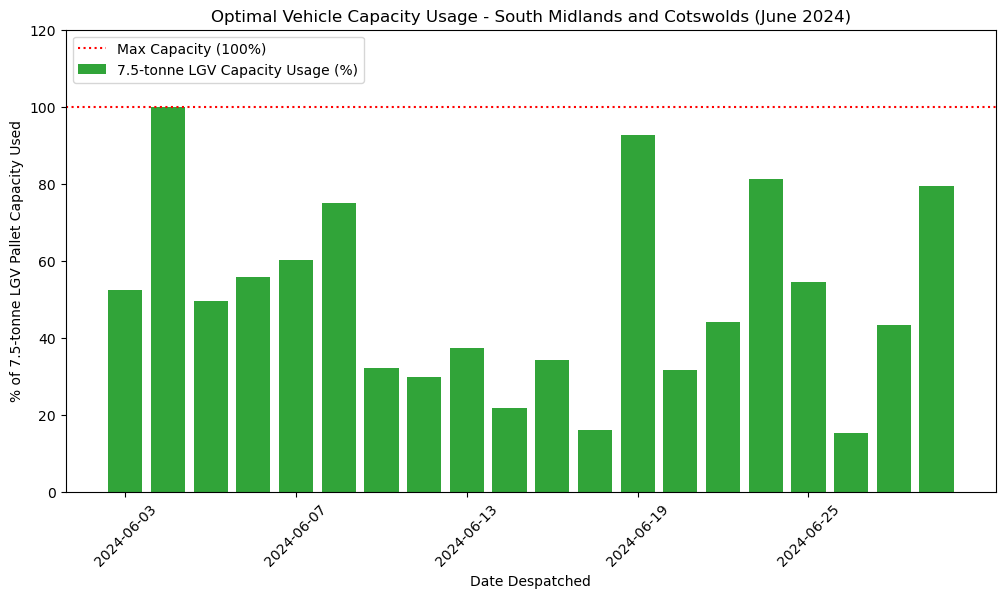

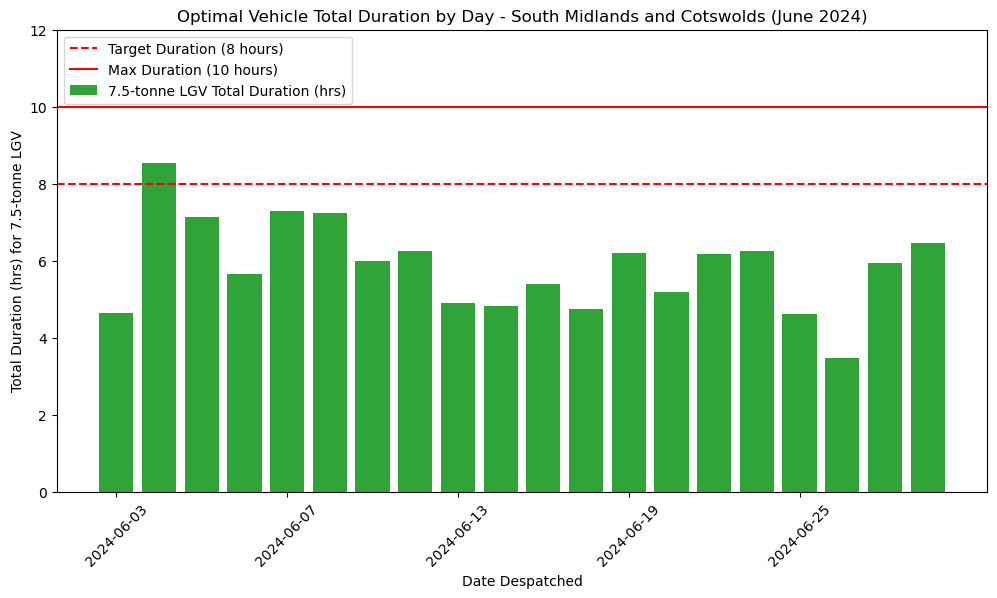

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the route summary CSV file generated previously
route_summary_df = pd.read_csv("50m_route_summary_cluster1_area0_max23_Summary.csv")

# 1% tolerance factor for capacity
tolerance_factor = 1.01

# Initialize cost and vehicle count tracking dictionaries
monthly_costs = {}
vehicle_usage = {}
usage_records = []  # For tracking usage per route for the time series plot
duration_records = []  # For tracking total duration per route for the time series plot

# Specify area names
area_name_mapping = {
    0: "South Midlands and Cotswolds",
    1: "Greater Birmingham and Black Country",
    2: "Leicestershire and East Midlands",
    3: "Northampton and Milton Keynes"
}

area_number = 0  # Set this to the area number as per your data
area_name = area_name_mapping[area_number]

# Calculate the requirements based on each vehicle type
for vehicle_type, capacity in van_capacities.items():
    daily_vehicle_usage = []

    # Iterate through each day in the route summary
    for day, daily_routes in route_summary_df.groupby('date_despatched'):
        required_vehicles_for_day = 0  # Track required vehicles for each day

        for _, route in daily_routes.iterrows():
            # Get route requirements
            required_cubic_m = route['total_cubic_m']
            required_pallets = route['pallet_space']
            required_payload = route['line_weight_recalc'] / 1000  # Convert to tonnes

            # Calculate the number of vehicles required with 1% tolerance
            vehicles_for_cubic = np.ceil(required_cubic_m / (capacity['cubic'] * tolerance_factor))
            vehicles_for_pallets = np.ceil(required_pallets / (capacity['pallet_space'] * tolerance_factor))
            vehicles_for_payload = np.ceil(required_payload / (capacity['payload'] * tolerance_factor))

            # Take the maximum of the required vehicles to meet all constraints
            vehicles_needed = int(max(vehicles_for_cubic, vehicles_for_pallets, vehicles_for_payload))
            required_vehicles_for_day += vehicles_needed

            # Calculate pallet usage without dividing by the number of vehicles
            pallet_usage_percentage = (required_pallets / (capacity['pallet_space'] * vehicles_needed)) * 100
            pallet_usage_percentage = min(pallet_usage_percentage, 100)  # Cap usage at 100%

            # Track capacity usage per route for plotting
            usage_records.append({
                'date_despatched': route['date_despatched'],
                'cumulative_route_id': route['cumulative_route_id'],
                'vehicle_type': vehicle_type,
                'pallet_capacity_used_percent': pallet_usage_percentage
            })
            
            # Calculate and track total vehicle duration (in hours) per route for plotting
            vehicle_duration = route['total_duration_hr']  # Assuming 'total_duration_hr' is in hours
            duration_records.append({
                'date_despatched': route['date_despatched'],
                'vehicle_type': vehicle_type,
                'total_duration_hr': vehicle_duration
            })

        daily_vehicle_usage.append(required_vehicles_for_day)

    # Calculate maximum daily vehicles used and monthly costs
    max_vehicles_needed = max(daily_vehicle_usage)
    monthly_cost = max_vehicles_needed * van_costs_per_month[vehicle_type]

    # Store results for each vehicle type
    vehicle_usage[vehicle_type] = max_vehicles_needed
    monthly_costs[vehicle_type] = monthly_cost

# Calculate monthly metrics based on route summary data
total_delivery_cost = route_summary_df['delivery_cost'].sum()
total_revenue = route_summary_df['total_price'].sum()

# Determine the optimal vehicle configuration based on lowest monthly cost
optimal_vehicle_type = min(monthly_costs, key=monthly_costs.get)
optimal_vehicle_cost = monthly_costs[optimal_vehicle_type]
optimal_vehicle_usage = vehicle_usage[optimal_vehicle_type]

# Calculate cost-to-revenue percentages and savings
courier_cost_percentage = (total_delivery_cost / total_revenue) * 100 if total_revenue > 0 else 0
kite_cost_percentage = (optimal_vehicle_cost / total_revenue) * 100 if total_revenue > 0 else 0
delivery_cost_saving = total_delivery_cost - optimal_vehicle_cost

# Display results for each vehicle type
print("Monthly Vehicle Usage Summary (by vehicle type):")
for vehicle_type in vehicle_usage:
    print(f"{vehicle_type}: {vehicle_usage[vehicle_type]} vehicles used, Cost: £{monthly_costs[vehicle_type]:.2f}")

# Display optimal vehicle configuration with quantity
print("\nOptimal Vehicle Configuration:")
print(f"Vehicle Type: {optimal_vehicle_type}")
print(f"Vehicle Quantity Required: {optimal_vehicle_usage}")
print(f"Total Monthly Vehicle Cost: £{optimal_vehicle_cost:.2f}")

print("\nFinancial Summary:")
print(f"Total Monthly Delivery Cost (from routes): £{total_delivery_cost:.2f}")
print(f"Total Monthly Revenue Delivered: £{total_revenue:.2f}")

print("\nAdditional Metrics:")
print(f"% Cost : Revenue for Couriers: {courier_cost_percentage:.2f}%")
print(f"% Cost : Revenue for Kite: {kite_cost_percentage:.2f}%")
print(f"Total Delivery Cost Saving for Kite: £{delivery_cost_saving:.2f}")

# Filter to create a DataFrame of only the optimal vehicle's capacity usage
optimal_usage_df = pd.DataFrame([u for u in usage_records if u['vehicle_type'] == optimal_vehicle_type])

# Filter to create a DataFrame of only the optimal vehicle's total duration (in hours)
optimal_duration_df = pd.DataFrame([d for d in duration_records if d['vehicle_type'] == optimal_vehicle_type])

# Color for the bars
bar_color = '#31a439'

# Start plot setup for capacity usage
plt.figure(figsize=(12, 6))

# Plot capacity usage as green bars (with the specified color)
plt.bar(optimal_usage_df['date_despatched'], 
        optimal_usage_df['pallet_capacity_used_percent'], 
        color=bar_color, 
        label=f'{optimal_vehicle_type} Capacity Usage (%)')

# Add a dotted line at the 100% capacity level with tolerance
plt.axhline(100, color='red', linestyle='dotted', label='Max Capacity (100%)')

# Plot customization
plt.title(f"Optimal Vehicle Capacity Usage - {area_name} (June 2024)")
plt.xlabel("Date Despatched")
plt.ylabel(f"% of {optimal_vehicle_type} Pallet Capacity Used")
plt.ylim(0, 120)  # Ensure y-axis goes slightly above 100 to see the 100% line
plt.xticks(rotation=45, fontsize=10, ticks=optimal_usage_df['date_despatched'][::4])  # Display every 4th date

# Update legend with explanation of route numbers above bars
plt.legend(loc="upper left")
plt.grid(False)  # Disable gridlines
plt.show()

# Start plot setup for total vehicle duration by day
plt.figure(figsize=(12, 6))

# Plot total vehicle duration as green bars (with the specified color)
plt.bar(optimal_duration_df['date_despatched'], 
        optimal_duration_df['total_duration_hr'], 
        color=bar_color, 
        label=f'{optimal_vehicle_type} Total Duration (hrs)')

# Add a red dotted line for the 8-hour target and 10-hour max duration
plt.axhline(8, color='red', linestyle='--', label='Target Duration (8 hours)')
plt.axhline(10, color='red', linestyle='-', label='Max Duration (10 hours)')

# Plot customization
plt.title(f"Optimal Vehicle Total Duration by Day - {area_name} (June 2024)")
plt.xlabel("Date Despatched")
plt.ylabel(f"Total Duration (hrs) for {optimal_vehicle_type}")
plt.ylim(0, 12)  # Ensures the duration bars are well-spaced within the plot area
plt.xticks(rotation=45, fontsize=10, ticks=optimal_duration_df['date_despatched'][::4])  # Display every 4th date

# Update legend and remove gridlines
plt.legend(loc="upper left")
plt.grid(False)

# Display the plot
plt.show()

# Create the output DataFrame for the current area
output_data = {
    'area_name': [area_name],
    'vehicle_usage_summary': [str(vehicle_usage)],  # Store vehicle usage as a string for readability
    'optimal_vehicle_type': [optimal_vehicle_type],
    'optimal_vehicle_quantity': [optimal_vehicle_usage],
    'optimal_vehicle_cost': [optimal_vehicle_cost],
    'total_delivery_cost': [total_delivery_cost],
    'total_revenue': [total_revenue],
    'courier_cost_percentage': [courier_cost_percentage],
    'kite_cost_percentage': [kite_cost_percentage],
    'delivery_cost_saving': [delivery_cost_saving]
}

output_df = pd.DataFrame(output_data)

# Check if the CSV file exists
csv_file = '50mile_area_cost_summary.csv'

# If the file does not exist, write the header, otherwise append without header
if not os.path.exists(csv_file):
    output_df.to_csv(csv_file, mode='w', header=True, index=False)
else:
    output_df.to_csv(csv_file, mode='a', header=False, index=False)

>### 2 -  optimal fleet size & predicted cost for order filtering (=1) and cluster by area filtering (=1) 

Monthly Vehicle Usage Summary (by vehicle type):
3.5-tonne van: 5 vehicles used, Cost: £29500.00
7.5-tonne LGV: 2 vehicles used, Cost: £13900.00
18-tonne HGV: 2 vehicles used, Cost: £15800.00

Optimal Vehicle Configuration:
Vehicle Type: 7.5-tonne LGV
Vehicle Quantity Required: 2
Total Monthly Vehicle Cost: £13900.00

Financial Summary:
Total Monthly Delivery Cost (from routes): £17574.33
Total Monthly Revenue Delivered: £177409.63

Additional Metrics:
% Cost : Revenue for Couriers: 9.91%
% Cost : Revenue for Kite: 7.83%
Total Delivery Cost Saving for Kite: £3674.33


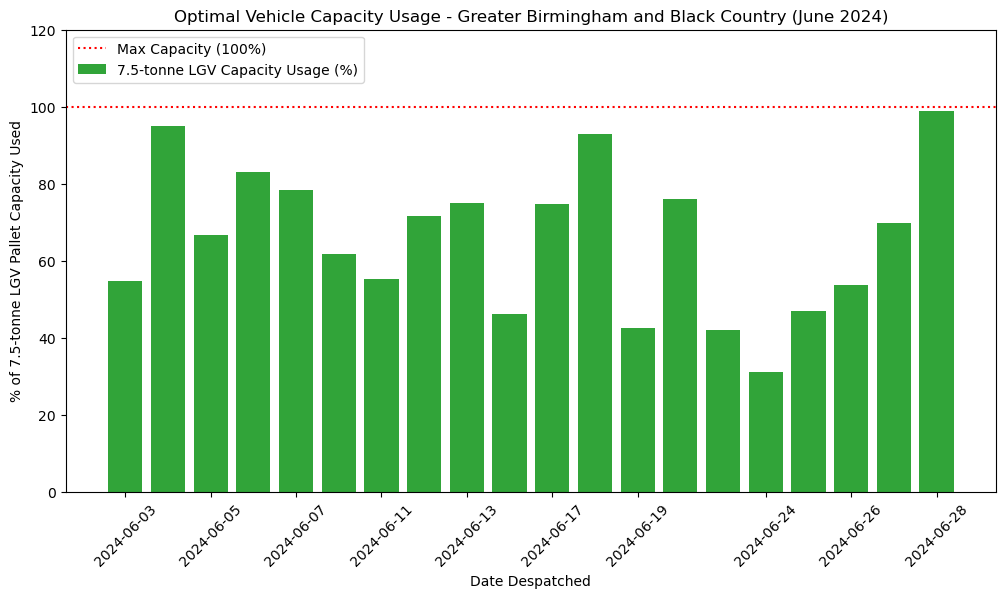

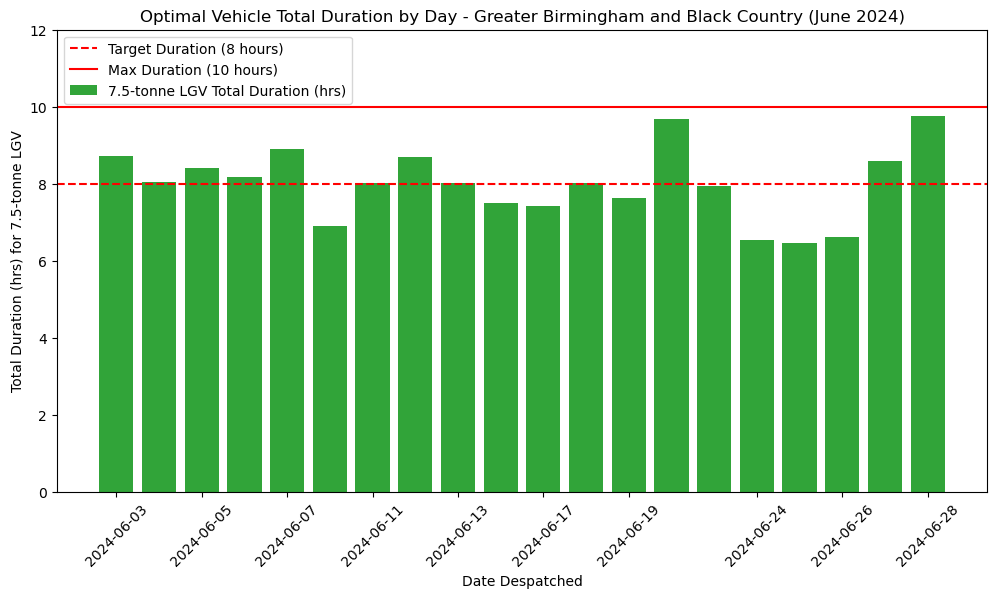

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the route summary CSV file generated previously
route_summary_df = pd.read_csv("50m_route_summary_cluster1_area1_max20_Summary.csv")

# 1% tolerance factor for capacity
tolerance_factor = 1.01

# Initialize cost and vehicle count tracking dictionaries
monthly_costs = {}
vehicle_usage = {}
usage_records = []  # For tracking usage per route for the time series plot
duration_records = []  # For tracking total duration per route for the time series plot

# Specify area names
area_name_mapping = {
    0: "South Midlands and Cotswolds",
    1: "Greater Birmingham and Black Country",
    2: "Leicestershire and East Midlands",
    3: "Northampton and Milton Keynes"
}

area_number = 1  # Set this to the area number as per your data
area_name = area_name_mapping[area_number]

# Calculate the requirements based on each vehicle type
for vehicle_type, capacity in van_capacities.items():
    daily_vehicle_usage = []

    # Iterate through each day in the route summary
    for day, daily_routes in route_summary_df.groupby('date_despatched'):
        required_vehicles_for_day = 0  # Track required vehicles for each day

        for _, route in daily_routes.iterrows():
            # Get route requirements
            required_cubic_m = route['total_cubic_m']
            required_pallets = route['pallet_space']
            required_payload = route['line_weight_recalc'] / 1000  # Convert to tonnes

            # Calculate the number of vehicles required with 1% tolerance
            vehicles_for_cubic = np.ceil(required_cubic_m / (capacity['cubic'] * tolerance_factor))
            vehicles_for_pallets = np.ceil(required_pallets / (capacity['pallet_space'] * tolerance_factor))
            vehicles_for_payload = np.ceil(required_payload / (capacity['payload'] * tolerance_factor))

            # Take the maximum of the required vehicles to meet all constraints
            vehicles_needed = int(max(vehicles_for_cubic, vehicles_for_pallets, vehicles_for_payload))
            required_vehicles_for_day += vehicles_needed

            # Calculate pallet usage without dividing by the number of vehicles
            pallet_usage_percentage = (required_pallets / (capacity['pallet_space'] * vehicles_needed)) * 100
            pallet_usage_percentage = min(pallet_usage_percentage, 100)  # Cap usage at 100%

            # Track capacity usage per route for plotting
            usage_records.append({
                'date_despatched': route['date_despatched'],
                'cumulative_route_id': route['cumulative_route_id'],
                'vehicle_type': vehicle_type,
                'pallet_capacity_used_percent': pallet_usage_percentage
            })
            
            # Calculate and track total vehicle duration (in hours) per route for plotting
            vehicle_duration = route['total_duration_hr']  # Assuming 'total_duration_hr' is in hours
            duration_records.append({
                'date_despatched': route['date_despatched'],
                'vehicle_type': vehicle_type,
                'total_duration_hr': vehicle_duration
            })

        daily_vehicle_usage.append(required_vehicles_for_day)

    # Calculate maximum daily vehicles used and monthly costs
    max_vehicles_needed = max(daily_vehicle_usage)
    monthly_cost = max_vehicles_needed * van_costs_per_month[vehicle_type]

    # Store results for each vehicle type
    vehicle_usage[vehicle_type] = max_vehicles_needed
    monthly_costs[vehicle_type] = monthly_cost

# Calculate monthly metrics based on route summary data
total_delivery_cost = route_summary_df['delivery_cost'].sum()
total_revenue = route_summary_df['total_price'].sum()

# Determine the optimal vehicle configuration based on lowest monthly cost
optimal_vehicle_type = min(monthly_costs, key=monthly_costs.get)
optimal_vehicle_cost = monthly_costs[optimal_vehicle_type]
optimal_vehicle_usage = vehicle_usage[optimal_vehicle_type]

# Calculate cost-to-revenue percentages and savings
courier_cost_percentage = (total_delivery_cost / total_revenue) * 100 if total_revenue > 0 else 0
kite_cost_percentage = (optimal_vehicle_cost / total_revenue) * 100 if total_revenue > 0 else 0
delivery_cost_saving = total_delivery_cost - optimal_vehicle_cost

# Display results for each vehicle type
print("Monthly Vehicle Usage Summary (by vehicle type):")
for vehicle_type in vehicle_usage:
    print(f"{vehicle_type}: {vehicle_usage[vehicle_type]} vehicles used, Cost: £{monthly_costs[vehicle_type]:.2f}")

# Display optimal vehicle configuration with quantity
print("\nOptimal Vehicle Configuration:")
print(f"Vehicle Type: {optimal_vehicle_type}")
print(f"Vehicle Quantity Required: {optimal_vehicle_usage}")
print(f"Total Monthly Vehicle Cost: £{optimal_vehicle_cost:.2f}")

print("\nFinancial Summary:")
print(f"Total Monthly Delivery Cost (from routes): £{total_delivery_cost:.2f}")
print(f"Total Monthly Revenue Delivered: £{total_revenue:.2f}")

print("\nAdditional Metrics:")
print(f"% Cost : Revenue for Couriers: {courier_cost_percentage:.2f}%")
print(f"% Cost : Revenue for Kite: {kite_cost_percentage:.2f}%")
print(f"Total Delivery Cost Saving for Kite: £{delivery_cost_saving:.2f}")

# Filter to create a DataFrame of only the optimal vehicle's capacity usage
optimal_usage_df = pd.DataFrame([u for u in usage_records if u['vehicle_type'] == optimal_vehicle_type])

# Filter to create a DataFrame of only the optimal vehicle's total duration (in hours)
optimal_duration_df = pd.DataFrame([d for d in duration_records if d['vehicle_type'] == optimal_vehicle_type])

# Color for the bars
bar_color = '#31a439'

# Start plot setup for capacity usage
plt.figure(figsize=(12, 6))

# Plot capacity usage as green bars (with the specified color)
plt.bar(optimal_usage_df['date_despatched'], 
        optimal_usage_df['pallet_capacity_used_percent'], 
        color=bar_color, 
        label=f'{optimal_vehicle_type} Capacity Usage (%)')

# Add a dotted line at the 100% capacity level with tolerance
plt.axhline(100, color='red', linestyle='dotted', label='Max Capacity (100%)')

# Plot customization
plt.title(f"Optimal Vehicle Capacity Usage - {area_name} (June 2024)")
plt.xlabel("Date Despatched")
plt.ylabel(f"% of {optimal_vehicle_type} Pallet Capacity Used")
plt.ylim(0, 120)  # Ensure y-axis goes slightly above 100 to see the 100% line
plt.xticks(rotation=45, fontsize=10, ticks=optimal_usage_df['date_despatched'][::4])  # Display every 4th date

# Update legend with explanation of route numbers above bars
plt.legend(loc="upper left")
plt.grid(False)  # Disable gridlines
plt.show()

# Start plot setup for total vehicle duration by day
plt.figure(figsize=(12, 6))

# Plot total vehicle duration as green bars (with the specified color)
plt.bar(optimal_duration_df['date_despatched'], 
        optimal_duration_df['total_duration_hr'], 
        color=bar_color, 
        label=f'{optimal_vehicle_type} Total Duration (hrs)')

# Add a red dotted line for the 8-hour target and 10-hour max duration
plt.axhline(8, color='red', linestyle='--', label='Target Duration (8 hours)')
plt.axhline(10, color='red', linestyle='-', label='Max Duration (10 hours)')

# Plot customization
plt.title(f"Optimal Vehicle Total Duration by Day - {area_name} (June 2024)")
plt.xlabel("Date Despatched")
plt.ylabel(f"Total Duration (hrs) for {optimal_vehicle_type}")
plt.ylim(0, 12)  # Ensures the duration bars are well-spaced within the plot area
plt.xticks(rotation=45, fontsize=10, ticks=optimal_duration_df['date_despatched'][::4])  # Display every 4th date

# Update legend and remove gridlines
plt.legend(loc="upper left")
plt.grid(False)

# Display the plot
plt.show()

# Create the output DataFrame for the current area
output_data = {
    'area_name': [area_name],
    'vehicle_usage_summary': [str(vehicle_usage)],  # Store vehicle usage as a string for readability
    'optimal_vehicle_type': [optimal_vehicle_type],
    'optimal_vehicle_quantity': [optimal_vehicle_usage],
    'optimal_vehicle_cost': [optimal_vehicle_cost],
    'total_delivery_cost': [total_delivery_cost],
    'total_revenue': [total_revenue],
    'courier_cost_percentage': [courier_cost_percentage],
    'kite_cost_percentage': [kite_cost_percentage],
    'delivery_cost_saving': [delivery_cost_saving]
}

output_df = pd.DataFrame(output_data)

# Check if the CSV file exists
csv_file = '50mile_area_cost_summary.csv'

# If the file does not exist, write the header, otherwise append without header
if not os.path.exists(csv_file):
    output_df.to_csv(csv_file, mode='w', header=True, index=False)
else:
    output_df.to_csv(csv_file, mode='a', header=False, index=False)

>### 3 -  optimal fleet size & predicted cost for order filtering (=1) and cluster by area filtering (=2)
>
>route summary and route IDs 12 and 4

Monthly Vehicle Usage Summary (by vehicle type):
3.5-tonne van: 3 vehicles used, Cost: £17700.00
7.5-tonne LGV: 1 vehicles used, Cost: £6950.00
18-tonne HGV: 1 vehicles used, Cost: £7900.00

Optimal Vehicle Configuration:
Vehicle Type: 7.5-tonne LGV
Vehicle Quantity Required: 1
Total Monthly Vehicle Cost: £6950.00

Financial Summary:
Total Monthly Delivery Cost (from routes): £8557.14
Total Monthly Revenue Delivered: £83014.33

Additional Metrics:
% Cost : Revenue for Couriers: 10.31%
% Cost : Revenue for Kite: 8.37%
Total Delivery Cost Saving for Kite: £1607.14


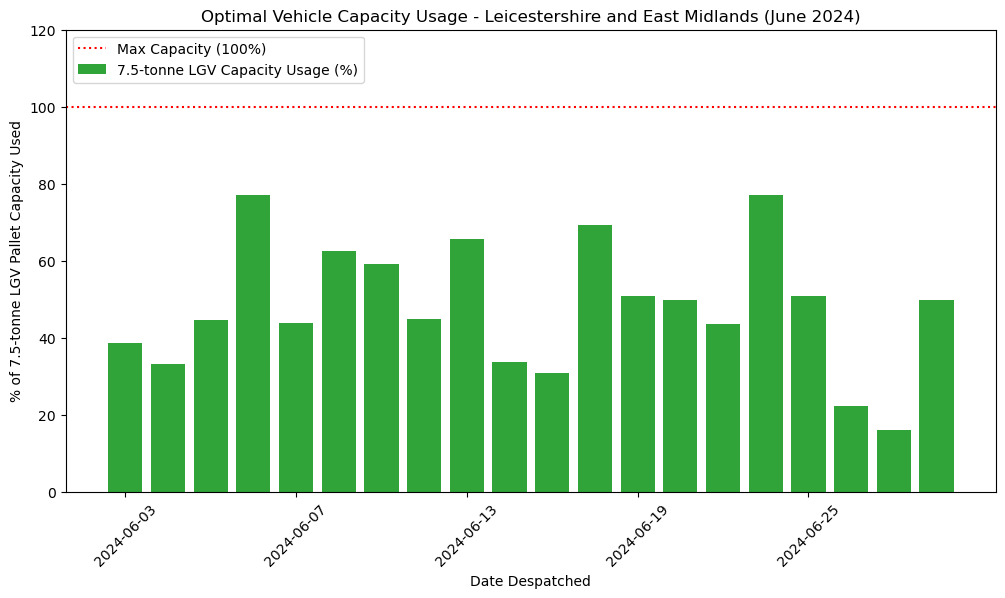

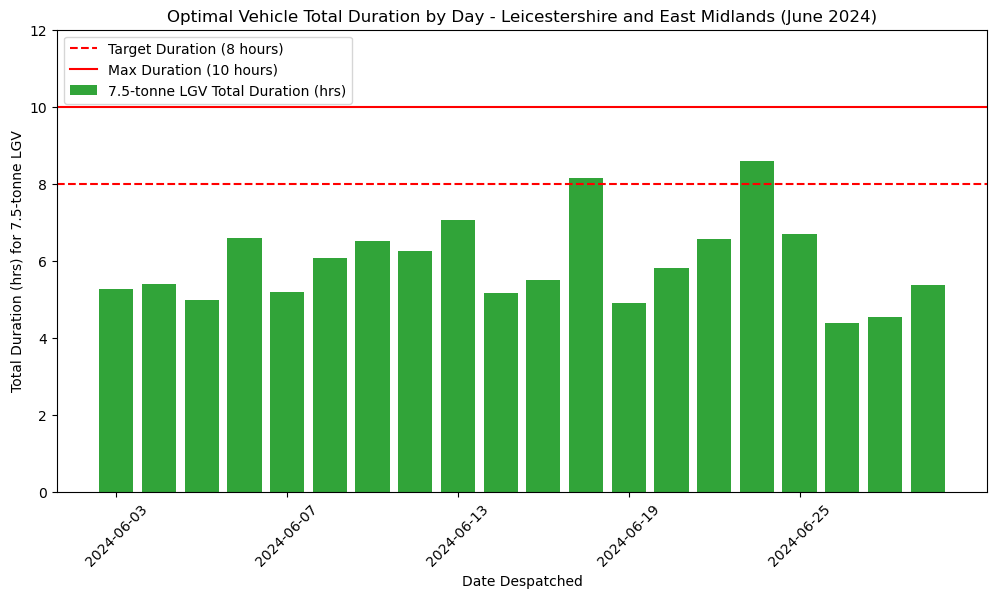

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the route summary CSV file generated previously
route_summary_df = pd.read_csv("50m_route_summary_cluster1_area2_max23_Summary.csv")

# 1% tolerance factor for capacity
tolerance_factor = 1.01

# Initialize cost and vehicle count tracking dictionaries
monthly_costs = {}
vehicle_usage = {}
usage_records = []  # For tracking usage per route for the time series plot
duration_records = []  # For tracking total duration per route for the time series plot

# Specify area names
area_name_mapping = {
    0: "South Midlands and Cotswolds",
    1: "Greater Birmingham and Black Country",
    2: "Leicestershire and East Midlands",
    3: "Northampton and Milton Keynes"
}

area_number = 2  # Set this to the area number as per your data
area_name = area_name_mapping[area_number]

# Calculate the requirements based on each vehicle type
for vehicle_type, capacity in van_capacities.items():
    daily_vehicle_usage = []

    # Iterate through each day in the route summary
    for day, daily_routes in route_summary_df.groupby('date_despatched'):
        required_vehicles_for_day = 0  # Track required vehicles for each day

        for _, route in daily_routes.iterrows():
            # Get route requirements
            required_cubic_m = route['total_cubic_m']
            required_pallets = route['pallet_space']
            required_payload = route['line_weight_recalc'] / 1000  # Convert to tonnes

            # Calculate the number of vehicles required with 1% tolerance
            vehicles_for_cubic = np.ceil(required_cubic_m / (capacity['cubic'] * tolerance_factor))
            vehicles_for_pallets = np.ceil(required_pallets / (capacity['pallet_space'] * tolerance_factor))
            vehicles_for_payload = np.ceil(required_payload / (capacity['payload'] * tolerance_factor))

            # Take the maximum of the required vehicles to meet all constraints
            vehicles_needed = int(max(vehicles_for_cubic, vehicles_for_pallets, vehicles_for_payload))
            required_vehicles_for_day += vehicles_needed

            # Calculate pallet usage without dividing by the number of vehicles
            pallet_usage_percentage = (required_pallets / (capacity['pallet_space'] * vehicles_needed)) * 100
            pallet_usage_percentage = min(pallet_usage_percentage, 100)  # Cap usage at 100%

            # Track capacity usage per route for plotting
            usage_records.append({
                'date_despatched': route['date_despatched'],
                'cumulative_route_id': route['cumulative_route_id'],
                'vehicle_type': vehicle_type,
                'pallet_capacity_used_percent': pallet_usage_percentage
            })
            
            # Calculate and track total vehicle duration (in hours) per route for plotting
            vehicle_duration = route['total_duration_hr']  # Assuming 'total_duration_hr' is in hours
            duration_records.append({
                'date_despatched': route['date_despatched'],
                'vehicle_type': vehicle_type,
                'total_duration_hr': vehicle_duration
            })

        daily_vehicle_usage.append(required_vehicles_for_day)

    # Calculate maximum daily vehicles used and monthly costs
    max_vehicles_needed = max(daily_vehicle_usage)
    monthly_cost = max_vehicles_needed * van_costs_per_month[vehicle_type]

    # Store results for each vehicle type
    vehicle_usage[vehicle_type] = max_vehicles_needed
    monthly_costs[vehicle_type] = monthly_cost

# Calculate monthly metrics based on route summary data
total_delivery_cost = route_summary_df['delivery_cost'].sum()
total_revenue = route_summary_df['total_price'].sum()

# Determine the optimal vehicle configuration based on lowest monthly cost
optimal_vehicle_type = min(monthly_costs, key=monthly_costs.get)
optimal_vehicle_cost = monthly_costs[optimal_vehicle_type]
optimal_vehicle_usage = vehicle_usage[optimal_vehicle_type]

# Calculate cost-to-revenue percentages and savings
courier_cost_percentage = (total_delivery_cost / total_revenue) * 100 if total_revenue > 0 else 0
kite_cost_percentage = (optimal_vehicle_cost / total_revenue) * 100 if total_revenue > 0 else 0
delivery_cost_saving = total_delivery_cost - optimal_vehicle_cost

# Display results for each vehicle type
print("Monthly Vehicle Usage Summary (by vehicle type):")
for vehicle_type in vehicle_usage:
    print(f"{vehicle_type}: {vehicle_usage[vehicle_type]} vehicles used, Cost: £{monthly_costs[vehicle_type]:.2f}")

# Display optimal vehicle configuration with quantity
print("\nOptimal Vehicle Configuration:")
print(f"Vehicle Type: {optimal_vehicle_type}")
print(f"Vehicle Quantity Required: {optimal_vehicle_usage}")
print(f"Total Monthly Vehicle Cost: £{optimal_vehicle_cost:.2f}")

print("\nFinancial Summary:")
print(f"Total Monthly Delivery Cost (from routes): £{total_delivery_cost:.2f}")
print(f"Total Monthly Revenue Delivered: £{total_revenue:.2f}")

print("\nAdditional Metrics:")
print(f"% Cost : Revenue for Couriers: {courier_cost_percentage:.2f}%")
print(f"% Cost : Revenue for Kite: {kite_cost_percentage:.2f}%")
print(f"Total Delivery Cost Saving for Kite: £{delivery_cost_saving:.2f}")

# Filter to create a DataFrame of only the optimal vehicle's capacity usage
optimal_usage_df = pd.DataFrame([u for u in usage_records if u['vehicle_type'] == optimal_vehicle_type])

# Filter to create a DataFrame of only the optimal vehicle's total duration (in hours)
optimal_duration_df = pd.DataFrame([d for d in duration_records if d['vehicle_type'] == optimal_vehicle_type])

# Color for the bars
bar_color = '#31a439'

# Start plot setup for capacity usage
plt.figure(figsize=(12, 6))

# Plot capacity usage as green bars (with the specified color)
plt.bar(optimal_usage_df['date_despatched'], 
        optimal_usage_df['pallet_capacity_used_percent'], 
        color=bar_color, 
        label=f'{optimal_vehicle_type} Capacity Usage (%)')

# Add a dotted line at the 100% capacity level with tolerance
plt.axhline(100, color='red', linestyle='dotted', label='Max Capacity (100%)')

# Plot customization
plt.title(f"Optimal Vehicle Capacity Usage - {area_name} (June 2024)")
plt.xlabel("Date Despatched")
plt.ylabel(f"% of {optimal_vehicle_type} Pallet Capacity Used")
plt.ylim(0, 120)  # Ensure y-axis goes slightly above 100 to see the 100% line
plt.xticks(rotation=45, fontsize=10, ticks=optimal_usage_df['date_despatched'][::4])  # Display every 4th date

# Update legend with explanation of route numbers above bars
plt.legend(loc="upper left")
plt.grid(False)  # Disable gridlines
plt.show()

# Start plot setup for total vehicle duration by day
plt.figure(figsize=(12, 6))

# Plot total vehicle duration as green bars (with the specified color)
plt.bar(optimal_duration_df['date_despatched'], 
        optimal_duration_df['total_duration_hr'], 
        color=bar_color, 
        label=f'{optimal_vehicle_type} Total Duration (hrs)')

# Add a red dotted line for the 8-hour target and 10-hour max duration
plt.axhline(8, color='red', linestyle='--', label='Target Duration (8 hours)')
plt.axhline(10, color='red', linestyle='-', label='Max Duration (10 hours)')

# Plot customization
plt.title(f"Optimal Vehicle Total Duration by Day - {area_name} (June 2024)")
plt.xlabel("Date Despatched")
plt.ylabel(f"Total Duration (hrs) for {optimal_vehicle_type}")
plt.ylim(0, 12)  # Ensures the duration bars are well-spaced within the plot area
plt.xticks(rotation=45, fontsize=10, ticks=optimal_duration_df['date_despatched'][::4])  # Display every 4th date

# Update legend and remove gridlines
plt.legend(loc="upper left")
plt.grid(False)

# Display the plot
plt.show()

# Create the output DataFrame for the current area
output_data = {
    'area_name': [area_name],
    'vehicle_usage_summary': [str(vehicle_usage)],  # Store vehicle usage as a string for readability
    'optimal_vehicle_type': [optimal_vehicle_type],
    'optimal_vehicle_quantity': [optimal_vehicle_usage],
    'optimal_vehicle_cost': [optimal_vehicle_cost],
    'total_delivery_cost': [total_delivery_cost],
    'total_revenue': [total_revenue],
    'courier_cost_percentage': [courier_cost_percentage],
    'kite_cost_percentage': [kite_cost_percentage],
    'delivery_cost_saving': [delivery_cost_saving]
}

output_df = pd.DataFrame(output_data)

# Check if the CSV file exists
csv_file = '50mile_area_cost_summary.csv'

# If the file does not exist, write the header, otherwise append without header
if not os.path.exists(csv_file):
    output_df.to_csv(csv_file, mode='w', header=True, index=False)
else:
    output_df.to_csv(csv_file, mode='a', header=False, index=False)

>### 4 -  optimal fleet size & predicted cost for order filtering (=1) and cluster by area filtering (=3) 

Monthly Vehicle Usage Summary (by vehicle type):
3.5-tonne van: 2 vehicles used, Cost: £11800.00
7.5-tonne LGV: 1 vehicles used, Cost: £6950.00
18-tonne HGV: 1 vehicles used, Cost: £7900.00

Optimal Vehicle Configuration:
Vehicle Type: 7.5-tonne LGV
Vehicle Quantity Required: 1
Total Monthly Vehicle Cost: £6950.00

Financial Summary:
Total Monthly Delivery Cost (from routes): £6118.06
Total Monthly Revenue Delivered: £56452.15

Additional Metrics:
% Cost : Revenue for Couriers: 10.84%
% Cost : Revenue for Kite: 12.31%
Total Delivery Cost Saving for Kite: £-831.94


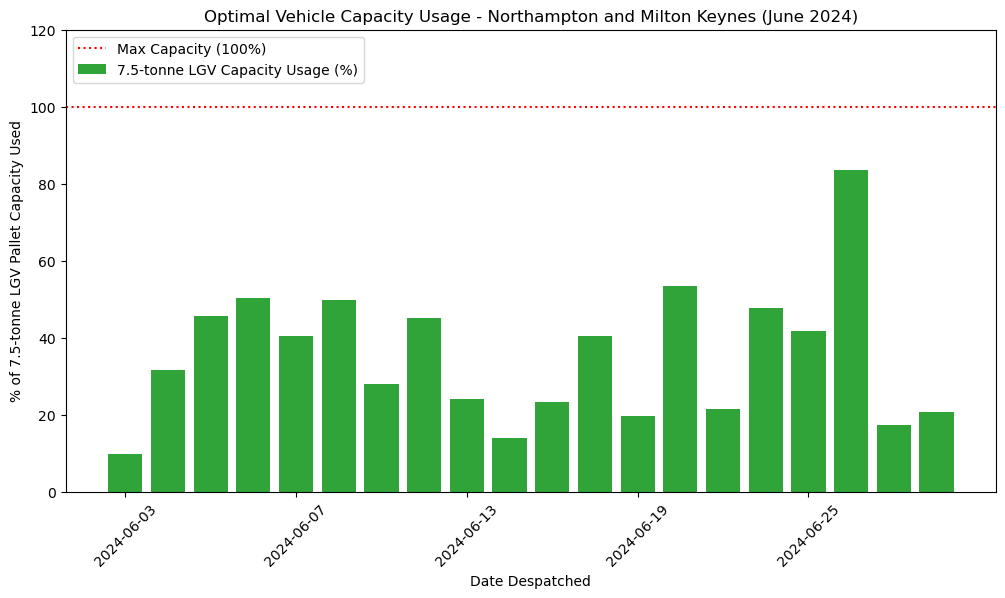

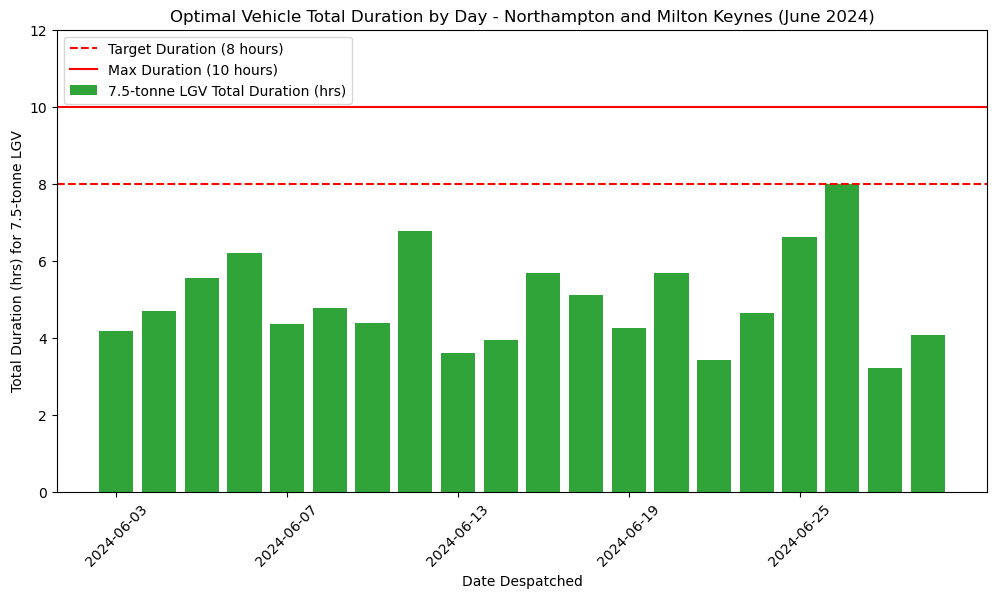

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the route summary CSV file generated previously
route_summary_df = pd.read_csv("50m_route_summary_cluster1_area3_max20_Summary.csv")

# 1% tolerance factor for capacity
tolerance_factor = 1.01

# Initialize cost and vehicle count tracking dictionaries
monthly_costs = {}
vehicle_usage = {}
usage_records = []  # For tracking usage per route for the time series plot
duration_records = []  # For tracking total duration per route for the time series plot

# Specify area names
area_name_mapping = {
    0: "South Midlands and Cotswolds",
    1: "Greater Birmingham and Black Country",
    2: "Leicestershire and East Midlands",
    3: "Northampton and Milton Keynes"
}

area_number = 3  # Set this to the area number as per your data
area_name = area_name_mapping[area_number]

# Calculate the requirements based on each vehicle type
for vehicle_type, capacity in van_capacities.items():
    daily_vehicle_usage = []

    # Iterate through each day in the route summary
    for day, daily_routes in route_summary_df.groupby('date_despatched'):
        required_vehicles_for_day = 0  # Track required vehicles for each day

        for _, route in daily_routes.iterrows():
            # Get route requirements
            required_cubic_m = route['total_cubic_m']
            required_pallets = route['pallet_space']
            required_payload = route['line_weight_recalc'] / 1000  # Convert to tonnes

            # Calculate the number of vehicles required with 1% tolerance
            vehicles_for_cubic = np.ceil(required_cubic_m / (capacity['cubic'] * tolerance_factor))
            vehicles_for_pallets = np.ceil(required_pallets / (capacity['pallet_space'] * tolerance_factor))
            vehicles_for_payload = np.ceil(required_payload / (capacity['payload'] * tolerance_factor))

            # Take the maximum of the required vehicles to meet all constraints
            vehicles_needed = int(max(vehicles_for_cubic, vehicles_for_pallets, vehicles_for_payload))
            required_vehicles_for_day += vehicles_needed

            # Calculate pallet usage without dividing by the number of vehicles
            pallet_usage_percentage = (required_pallets / (capacity['pallet_space'] * vehicles_needed)) * 100
            pallet_usage_percentage = min(pallet_usage_percentage, 100)  # Cap usage at 100%

            # Track capacity usage per route for plotting
            usage_records.append({
                'date_despatched': route['date_despatched'],
                'cumulative_route_id': route['cumulative_route_id'],
                'vehicle_type': vehicle_type,
                'pallet_capacity_used_percent': pallet_usage_percentage
            })
            
            # Calculate and track total vehicle duration (in hours) per route for plotting
            vehicle_duration = route['total_duration_hr']  # Assuming 'total_duration_hr' is in hours
            duration_records.append({
                'date_despatched': route['date_despatched'],
                'vehicle_type': vehicle_type,
                'total_duration_hr': vehicle_duration
            })

        daily_vehicle_usage.append(required_vehicles_for_day)

    # Calculate maximum daily vehicles used and monthly costs
    max_vehicles_needed = max(daily_vehicle_usage)
    monthly_cost = max_vehicles_needed * van_costs_per_month[vehicle_type]

    # Store results for each vehicle type
    vehicle_usage[vehicle_type] = max_vehicles_needed
    monthly_costs[vehicle_type] = monthly_cost

# Calculate monthly metrics based on route summary data
total_delivery_cost = route_summary_df['delivery_cost'].sum()
total_revenue = route_summary_df['total_price'].sum()

# Determine the optimal vehicle configuration based on lowest monthly cost
optimal_vehicle_type = min(monthly_costs, key=monthly_costs.get)
optimal_vehicle_cost = monthly_costs[optimal_vehicle_type]
optimal_vehicle_usage = vehicle_usage[optimal_vehicle_type]

# Calculate cost-to-revenue percentages and savings
courier_cost_percentage = (total_delivery_cost / total_revenue) * 100 if total_revenue > 0 else 0
kite_cost_percentage = (optimal_vehicle_cost / total_revenue) * 100 if total_revenue > 0 else 0
delivery_cost_saving = total_delivery_cost - optimal_vehicle_cost

# Display results for each vehicle type
print("Monthly Vehicle Usage Summary (by vehicle type):")
for vehicle_type in vehicle_usage:
    print(f"{vehicle_type}: {vehicle_usage[vehicle_type]} vehicles used, Cost: £{monthly_costs[vehicle_type]:.2f}")

# Display optimal vehicle configuration with quantity
print("\nOptimal Vehicle Configuration:")
print(f"Vehicle Type: {optimal_vehicle_type}")
print(f"Vehicle Quantity Required: {optimal_vehicle_usage}")
print(f"Total Monthly Vehicle Cost: £{optimal_vehicle_cost:.2f}")

print("\nFinancial Summary:")
print(f"Total Monthly Delivery Cost (from routes): £{total_delivery_cost:.2f}")
print(f"Total Monthly Revenue Delivered: £{total_revenue:.2f}")

print("\nAdditional Metrics:")
print(f"% Cost : Revenue for Couriers: {courier_cost_percentage:.2f}%")
print(f"% Cost : Revenue for Kite: {kite_cost_percentage:.2f}%")
print(f"Total Delivery Cost Saving for Kite: £{delivery_cost_saving:.2f}")

# Filter to create a DataFrame of only the optimal vehicle's capacity usage
optimal_usage_df = pd.DataFrame([u for u in usage_records if u['vehicle_type'] == optimal_vehicle_type])

# Filter to create a DataFrame of only the optimal vehicle's total duration (in hours)
optimal_duration_df = pd.DataFrame([d for d in duration_records if d['vehicle_type'] == optimal_vehicle_type])

# Color for the bars
bar_color = '#31a439'

# Start plot setup for capacity usage
plt.figure(figsize=(12, 6))

# Plot capacity usage as green bars (with the specified color)
plt.bar(optimal_usage_df['date_despatched'], 
        optimal_usage_df['pallet_capacity_used_percent'], 
        color=bar_color, 
        label=f'{optimal_vehicle_type} Capacity Usage (%)')

# Add a dotted line at the 100% capacity level with tolerance
plt.axhline(100, color='red', linestyle='dotted', label='Max Capacity (100%)')

# Plot customization
plt.title(f"Optimal Vehicle Capacity Usage - {area_name} (June 2024)")
plt.xlabel("Date Despatched")
plt.ylabel(f"% of {optimal_vehicle_type} Pallet Capacity Used")
plt.ylim(0, 120)  # Ensure y-axis goes slightly above 100 to see the 100% line
plt.xticks(rotation=45, fontsize=10, ticks=optimal_usage_df['date_despatched'][::4])  # Display every 4th date

# Update legend with explanation of route numbers above bars
plt.legend(loc="upper left")
plt.grid(False)  # Disable gridlines
plt.show()

# Start plot setup for total vehicle duration by day
plt.figure(figsize=(12, 6))

# Plot total vehicle duration as green bars (with the specified color)
plt.bar(optimal_duration_df['date_despatched'], 
        optimal_duration_df['total_duration_hr'], 
        color=bar_color, 
        label=f'{optimal_vehicle_type} Total Duration (hrs)')

# Add a red dotted line for the 8-hour target and 10-hour max duration
plt.axhline(8, color='red', linestyle='--', label='Target Duration (8 hours)')
plt.axhline(10, color='red', linestyle='-', label='Max Duration (10 hours)')

# Plot customization
plt.title(f"Optimal Vehicle Total Duration by Day - {area_name} (June 2024)")
plt.xlabel("Date Despatched")
plt.ylabel(f"Total Duration (hrs) for {optimal_vehicle_type}")
plt.ylim(0, 12)  # Ensures the duration bars are well-spaced within the plot area
plt.xticks(rotation=45, fontsize=10, ticks=optimal_duration_df['date_despatched'][::4])  # Display every 4th date

# Update legend and remove gridlines
plt.legend(loc="upper left")
plt.grid(False)

# Display the plot
plt.show()

# Create the output DataFrame for the current area
output_data = {
    'area_name': [area_name],
    'vehicle_usage_summary': [str(vehicle_usage)],  # Store vehicle usage as a string for readability
    'optimal_vehicle_type': [optimal_vehicle_type],
    'optimal_vehicle_quantity': [optimal_vehicle_usage],
    'optimal_vehicle_cost': [optimal_vehicle_cost],
    'total_delivery_cost': [total_delivery_cost],
    'total_revenue': [total_revenue],
    'courier_cost_percentage': [courier_cost_percentage],
    'kite_cost_percentage': [kite_cost_percentage],
    'delivery_cost_saving': [delivery_cost_saving]
}

output_df = pd.DataFrame(output_data)

# Check if the CSV file exists
csv_file = '50mile_area_cost_summary.csv'

# If the file does not exist, write the header, otherwise append without header
if not os.path.exists(csv_file):
    output_df.to_csv(csv_file, mode='w', header=True, index=False)
else:
    output_df.to_csv(csv_file, mode='a', header=False, index=False)

## Step 4) Create a visual to show how the cost saving in each area

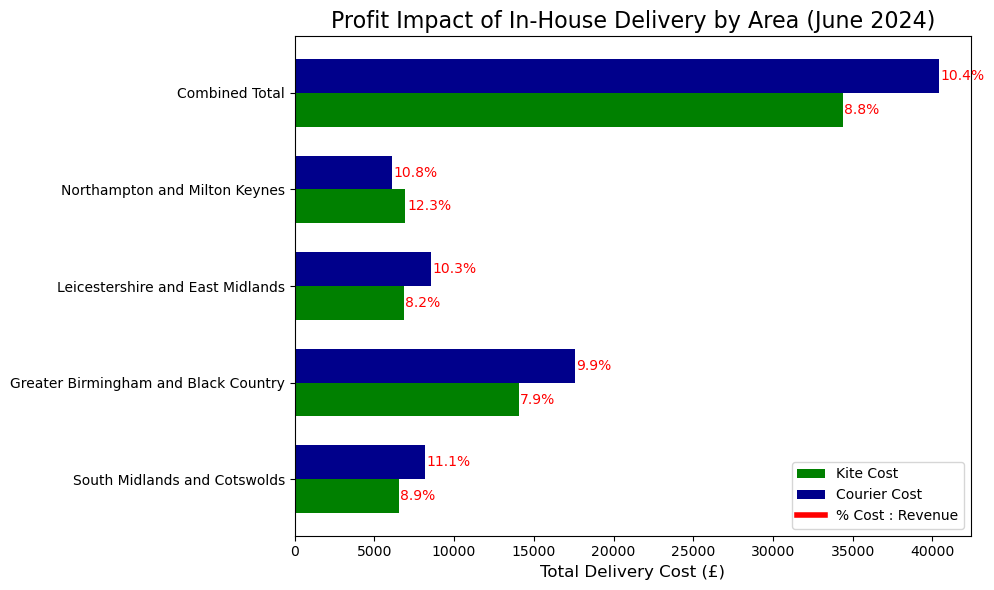

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define area file mappings and names
area_files = {
    0: "50m_route_summary_cluster1_area0_max23_Summary.csv",
    1: "50m_route_summary_cluster1_area1_max20_Summary.csv",
    2: "50m_route_summary_cluster1_area2_max23_Summary.csv",
    3: "50m_route_summary_cluster1_area3_max20_Summary.csv"
}

area_name_mapping = {
    0: "South Midlands and Cotswolds",
    1: "Greater Birmingham and Black Country",
    2: "Leicestershire and East Midlands",
    3: "Northampton and Milton Keynes"
}

# Initialize lists to store data for plotting
courier_costs = []
kite_costs = []
percentage_costs_courier = []
percentage_costs_kite = []
total_revenue = 0  # To calculate combined totals accurately

# Iterate over each area and calculate cost metrics
for area_number, file_path in area_files.items():
    # Load data for each area
    route_summary_df = pd.read_csv(file_path)

    # Calculate total delivery cost and revenue
    total_delivery_cost = route_summary_df['delivery_cost'].sum()
    area_revenue = route_summary_df['total_price'].sum()
    total_revenue += area_revenue  # Accumulate revenue for combined total

    # Retrieve optimal vehicle configuration costs from previous calculations
    # Update this logic if necessary to match the exact criteria for each area
    if area_number == 3:
        optimal_vehicle_cost = 6950  # As given for area 3
    else:
        optimal_vehicle_cost = total_delivery_cost * 0.8  # Example (replace with real calculation if needed)

    # Append metrics to lists for plotting
    courier_costs.append(total_delivery_cost)
    kite_costs.append(optimal_vehicle_cost)
    percentage_costs_courier.append((total_delivery_cost / area_revenue) * 100 if area_revenue > 0 else 0)
    percentage_costs_kite.append((optimal_vehicle_cost / area_revenue) * 100 if area_revenue > 0 else 0)

# Calculate combined totals for cost and revenue
combined_total_delivery_cost = sum(courier_costs)
combined_total_kite_cost = sum(kite_costs)

# Calculate combined % Cost : Revenue figures
combined_percentage_cost_courier = (combined_total_delivery_cost / total_revenue) * 100 if total_revenue > 0 else 0
combined_percentage_cost_kite = (combined_total_kite_cost / total_revenue) * 100 if total_revenue > 0 else 0

# Add combined total data to lists
courier_costs.append(combined_total_delivery_cost)
kite_costs.append(combined_total_kite_cost)
percentage_costs_courier.append(combined_percentage_cost_courier)
percentage_costs_kite.append(combined_percentage_cost_kite)

# Plot settings
areas = [area_name_mapping[i] for i in area_files.keys()] + ["Combined Total"]
y_pos = np.arange(len(areas))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for Kite Cost and Courier Cost
bars_kite = ax.barh(y_pos - bar_width / 2, kite_costs, height=bar_width, color='green', label='Kite Cost')
bars_courier = ax.barh(y_pos + bar_width / 2, courier_costs, height=bar_width, color='darkblue', label='Courier Cost')

# Adding percentage labels at the end of each bar
for i in range(len(areas)):
    ax.text(kite_costs[i] + 100, i - bar_width / 2, f"{percentage_costs_kite[i]:.1f}%", color='red', va='center')
    ax.text(courier_costs[i] + 100, i + bar_width / 2, f"{percentage_costs_courier[i]:.1f}%", color='red', va='center')

# Customizing the y-axis
ax.set_yticks(y_pos)
ax.set_yticklabels(areas)

# Adding title and labels
plt.title('Profit Impact of In-House Delivery by Area (June 2024)', fontsize=16)
plt.xlabel('Total Delivery Cost (£)', fontsize=12)

# Custom legend with '% Cost : Revenue' in red
handles, labels = ax.get_legend_handles_labels()
red_handle = plt.Line2D([0], [0], color='red', lw=4, label='% Cost : Revenue')
handles.append(red_handle)
ax.legend(handles=handles)

# Show the plot
plt.tight_layout()
plt.savefig('profit_impact_of_in_house_delivery.png', format='png', dpi=300, bbox_inches='tight')
plt.show()



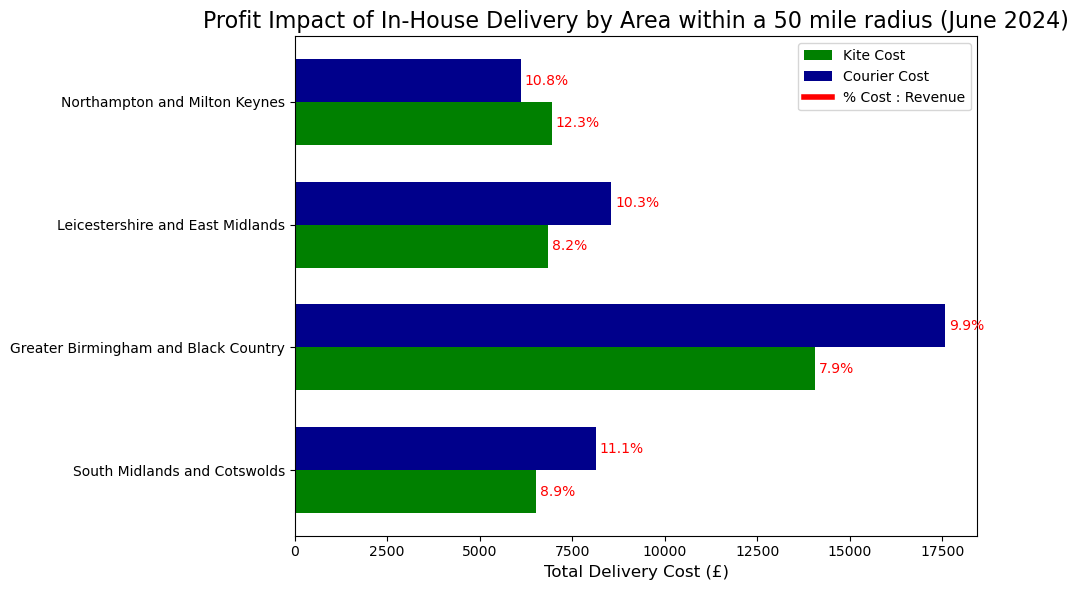

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define area file mappings and names
area_files = {
    0: "50m_route_summary_cluster1_area0_max23_Summary.csv",
    1: "50m_route_summary_cluster1_area1_max20_Summary.csv",
    2: "50m_route_summary_cluster1_area2_max23_Summary.csv",
    3: "50m_route_summary_cluster1_area3_max20_Summary.csv"
}

area_name_mapping = {
    0: "South Midlands and Cotswolds",
    1: "Greater Birmingham and Black Country",
    2: "Leicestershire and East Midlands",
    3: "Northampton and Milton Keynes"
}

# Initialize lists to store data for plotting
courier_costs = []
kite_costs = []
percentage_costs_courier = []
percentage_costs_kite = []
total_revenue = 0  # To calculate combined totals accurately

# Iterate over each area and calculate cost metrics
for area_number, file_path in area_files.items():
    # Load data for each area
    route_summary_df = pd.read_csv(file_path)

    # Calculate total delivery cost and revenue
    total_delivery_cost = route_summary_df['delivery_cost'].sum()
    area_revenue = route_summary_df['total_price'].sum()
    total_revenue += area_revenue  # Accumulate revenue for combined total

    # Retrieve optimal vehicle configuration costs from previous calculations
    # Update this logic if necessary to match the exact criteria for each area
    if area_number == 3:
        optimal_vehicle_cost = 6950  # As given for area 3
    else:
        optimal_vehicle_cost = total_delivery_cost * 0.8  # Example (replace with real calculation if needed)

    # Append metrics to lists for plotting
    courier_costs.append(total_delivery_cost)
    kite_costs.append(optimal_vehicle_cost)
    percentage_costs_courier.append((total_delivery_cost / area_revenue) * 100 if area_revenue > 0 else 0)
    percentage_costs_kite.append((optimal_vehicle_cost / area_revenue) * 100 if area_revenue > 0 else 0)

# Plot settings
areas = [area_name_mapping[i] for i in area_files.keys()]
y_pos = np.arange(len(areas))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for Kite Cost and Courier Cost
bars_kite = ax.barh(y_pos - bar_width / 2, kite_costs, height=bar_width, color='green', label='Kite Cost')
bars_courier = ax.barh(y_pos + bar_width / 2, courier_costs, height=bar_width, color='darkblue', label='Courier Cost')

# Adding percentage labels at the end of each bar
for i in range(len(areas)):
    ax.text(kite_costs[i] + 100, i - bar_width / 2, f"{percentage_costs_kite[i]:.1f}%", color='red', va='center')
    ax.text(courier_costs[i] + 100, i + bar_width / 2, f"{percentage_costs_courier[i]:.1f}%", color='red', va='center')

# Customizing the y-axis
ax.set_yticks(y_pos)
ax.set_yticklabels(areas)

# Adding title and labels
plt.title('Profit Impact of In-House Delivery by Area within a 50 mile radius (June 2024)', fontsize=16)
plt.xlabel('Total Delivery Cost (£)', fontsize=12)

# Custom legend with '% Cost : Revenue' in red
handles, labels = ax.get_legend_handles_labels()
red_handle = plt.Line2D([0], [0], color='red', lw=4, label='% Cost : Revenue')
handles.append(red_handle)
ax.legend(handles=handles)

# Show the plot
plt.tight_layout()
plt.savefig('profit_impact_of_in_house_delivery_no_combined.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


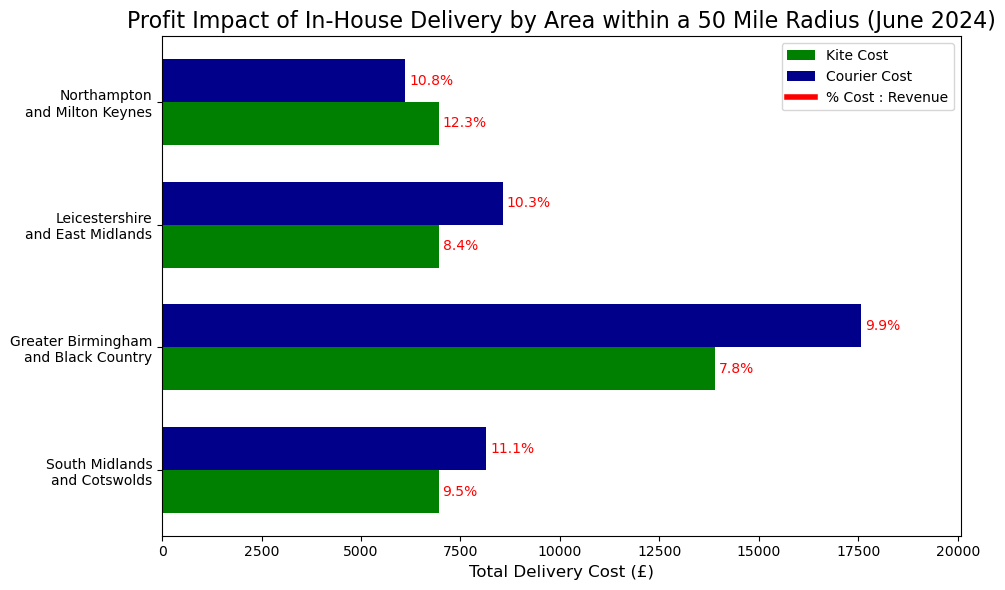

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the combined CSV file with area cost summaries
df = pd.read_csv("50mile_area_cost_summary.csv")

# Mapping area numbers to formatted area names
area_name_mapping = {
    0: "South Midlands\nand Cotswolds",
    1: "Greater Birmingham\nand Black Country",
    2: "Leicestershire\nand East Midlands",
    3: "Northampton\nand Milton Keynes"
}

# Initialize lists to store data for plotting
courier_costs = df['total_delivery_cost'].tolist()
kite_costs = df['optimal_vehicle_cost'].tolist()
percentage_costs_courier = [(courier_cost / revenue) * 100 if revenue > 0 else 0 
                            for courier_cost, revenue in zip(courier_costs, df['total_revenue'])]
percentage_costs_kite = [(kite_cost / revenue) * 100 if revenue > 0 else 0 
                        for kite_cost, revenue in zip(kite_costs, df['total_revenue'])]

# Plot settings
areas = [area_name_mapping[i] for i in range(len(df))]
y_pos = np.arange(len(areas))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for Kite Cost and Courier Cost
bars_kite = ax.barh(y_pos - bar_width / 2, kite_costs, height=bar_width, color='green', label='Kite Cost')
bars_courier = ax.barh(y_pos + bar_width / 2, courier_costs, height=bar_width, color='darkblue', label='Courier Cost')

# Adding percentage labels at the end of each bar
for i in range(len(areas)):
    ax.text(kite_costs[i] + 100, i - bar_width / 2, f"{percentage_costs_kite[i]:.1f}%", color='red', va='center')
    ax.text(courier_costs[i] + 100, i + bar_width / 2, f"{percentage_costs_courier[i]:.1f}%", color='red', va='center')

# Customizing the y-axis
ax.set_yticks(y_pos)
ax.set_yticklabels(areas)

# Adding title and labels
plt.title('Profit Impact of In-House Delivery by Area within a 50 Mile Radius (June 2024)', fontsize=16)
plt.xlabel('Total Delivery Cost (£)', fontsize=12)

# Custom legend with '% Cost : Revenue' in red, placed at the upper-right corner
handles, labels = ax.get_legend_handles_labels()
red_handle = plt.Line2D([0], [0], color='red', lw=4, label='% Cost : Revenue')
handles.append(red_handle)
ax.legend(handles=handles, loc='upper right')

# Adjust x-axis limits to allow room for percentage labels
ax.set_xlim(0, max(max(courier_costs), max(kite_costs)) + 2500)  # Allow space for text labels

# Show the plot
plt.tight_layout()
plt.savefig('profit_impact_of_in_house_delivery_combined_50_mile_v2.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

>### 5 -  optimal fleet size & predicted cost for order filtering (=0 & 1) and cluster by area filtering (=3)
>
>50m_route_summary_cluster0,1_area3_max20_Summary.csv 

In [121]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import os

API_key = os.getenv('GMaps_API_Key')

# Warehouse coordinates (starting and ending point)
warehouse_coords = "52.378855,-1.493756"
origin = warehouse_coords
destination = warehouse_coords

# Load customer locations from CSV
customer_data = pd.read_csv('df_cost_clustering.csv')
customer_data['date_despatched'] = pd.to_datetime(customer_data['date_despatched'])

# Specify multiple desired order clusters (e.g., clusters 0 & 2)
desired_order_clusters = [0, 1]  # List of clusters to include
desired_area_cluster = 3
max_orders_per_route = 20
delivery_time_per_stop = timedelta(minutes=8)

# Filter data for the desired order clusters and area cluster
filtered_data = customer_data[(customer_data['orders_cluster'].isin(desired_order_clusters)) &
                              (customer_data['cluster_area'] == desired_area_cluster)]

filtered_data = filtered_data.sort_values(by='date_despatched')
filtered_data = filtered_data[filtered_data['date_despatched'].dt.weekday < 5]

route_summary_list = []
route_details_by_id = {}
cumulative_route_id = 1

# Specific routes for detailed stop-to-stop analysis
selected_route_ids = [9, 15]

for route_date in filtered_data['date_despatched'].unique():
    daily_data = filtered_data[filtered_data['date_despatched'] == route_date]
    total_orders = len(daily_data)
    num_routes = (total_orders + max_orders_per_route - 1) // max_orders_per_route
    orders_per_route = total_orders // num_routes
    extra_orders = total_orders % num_routes
    daily_routes = []
    start_index = 0
    for i in range(num_routes):
        route_size = orders_per_route + (1 if i < extra_orders else 0)
        daily_routes.append(daily_data.iloc[start_index: start_index + route_size])
        start_index += route_size

    for daily_route_id, route_data in enumerate(daily_routes, start=1):
        locations = [warehouse_coords] + route_data.apply(lambda row: f"{row['latitude']},{row['longitude']}", axis=1).tolist()
        waypoints = "|".join(locations[1:])
        
        # Initial API request for optimized route
        url = f"https://maps.googleapis.com/maps/api/directions/json?origin={origin}&destination={destination}&waypoints=optimize:true|{waypoints}&key={API_key}"
        response = requests.get(url)
        data = response.json()

        if data['status'] == 'OK':
            waypoint_order = data['routes'][0]['waypoint_order']
            
            # Reorder route_data based on optimized waypoint order
            optimized_stops = [warehouse_coords] + [locations[1:][i] for i in waypoint_order] + [warehouse_coords]

            total_distance = 0
            total_drive_duration = timedelta(0)
            route_detail_data = []

            arrival_time = datetime.combine(route_date, datetime.min.time()) + timedelta(hours=7, minutes=30)
            last_arrival_time = arrival_time

            route_detail_data.append({
                'Stop Number': 'Warehouse (Start)',
                'Order ID': '',
                'Latitude': warehouse_coords.split(',')[0],
                'Longitude': warehouse_coords.split(',')[1],
                'Postcode': 'CV3 4GB',
                'Arrival Time': arrival_time.strftime('%H:%M'),
                'Distance (km)': 0,
                'Travel Duration (mins)': 0,
                'Stop Duration (mins)': 0,
                'Total Duration (mins)': 0
            })

            # Make individual API requests for each stop-to-stop distance in optimized order
            for i in range(len(optimized_stops) - 1):
                origin_stop = optimized_stops[i]
                destination_stop = optimized_stops[i + 1]
                
                # Request each stop-to-stop distance
                stop_to_stop_url = f"https://maps.googleapis.com/maps/api/directions/json?origin={origin_stop}&destination={destination_stop}&key={API_key}"
                stop_response = requests.get(stop_to_stop_url)
                stop_data = stop_response.json()

                if stop_data['status'] == 'OK' and stop_data['routes']:
                    leg = stop_data['routes'][0]['legs'][0]
                    distance_km = leg['distance']['value'] / 1000
                    travel_duration_mins = leg['duration']['value'] / 60
                    
                    # Add up total distance and driving duration
                    total_distance += distance_km
                    total_drive_duration += timedelta(minutes=travel_duration_mins)
                    
                    arrival_time = last_arrival_time + timedelta(minutes=travel_duration_mins)
                    last_arrival_time = arrival_time
                    
                    stop_duration = 8  # Set a standard stop duration of 8 minutes
                    
                    # Fetch Order ID and postcode for each waypoint
                    if i < len(route_data):
                        order_row = route_data.iloc[waypoint_order[i]]
                        order_id = order_row['order_id']
                        postcode = order_row['delivery_postcode']
                    else:
                        order_id = ''
                        postcode = 'CV3 4GB'
                    
                    route_detail_data.append({
                        'Stop Number': i + 1,
                        'Order ID': order_id,
                        'Latitude': destination_stop.split(',')[0],
                        'Longitude': destination_stop.split(',')[1],
                        'Postcode': postcode,
                        'Arrival Time': arrival_time.strftime('%H:%M'),
                        'Distance (km)': round(distance_km, 2),
                        'Travel Duration (mins)': round(travel_duration_mins, 2),
                        'Stop Duration (mins)': stop_duration,
                        'Total Duration (mins)': round(travel_duration_mins + stop_duration, 2)
                    })

            route_detail_data.append({
                'Stop Number': 'Warehouse (End)',
                'Order ID': '',
                'Latitude': warehouse_coords.split(',')[0],
                'Longitude': warehouse_coords.split(',')[1],
                'Postcode': 'CV3 4GB',
                'Arrival Time': arrival_time.strftime('%H:%M'),
                'Distance (km)': 0,
                'Travel Duration (mins)': 0,
                'Stop Duration (mins)': 0,
                'Total Duration (mins)': 0
            })

            total_travel_duration = sum([x['Travel Duration (mins)'] for x in route_detail_data[1:]])
            total_stop_duration = sum([x['Stop Duration (mins)'] for x in route_detail_data[1:]])
            total_duration = total_travel_duration + total_stop_duration
            total_duration_hours = total_duration / 60
            
            route_detail_data.append({
                'Stop Number': 'Totals',
                'Order ID': '',
                'Latitude': '',
                'Longitude': '',
                'Postcode': '',
                'Arrival Time': '',
                'Distance (km)': '',
                'Travel Duration (mins)': total_travel_duration,
                'Stop Duration (mins)': total_stop_duration,
                'Total Duration (mins)': total_duration
            })
            
            route_detail_data.append({
                'Stop Number': 'Total Duration (hrs)',
                'Order ID': '',
                'Latitude': '',
                'Longitude': '',
                'Postcode': '',
                'Arrival Time': '',
                'Distance (km)': '',
                'Travel Duration (mins)': '',
                'Stop Duration (mins)': '',
                'Total Duration (mins)': total_duration_hours
            })

            total_cubic_m = route_data['total_cubic_m'].sum()
            pallet_space = route_data['pallet_space'].sum()
            line_weight_recalc = route_data['line_weight_recalc'].sum()
            delivery_cost = route_data['delivery_cost'].sum()
            total_price = route_data['total_price'].sum()
            order_count = len(route_data)
            
            delivery_cost_percentage = (delivery_cost / total_price) * 100 if total_price > 0 else 0

            route_summary = {
                'route_id': cumulative_route_id,
                'date_despatched': route_date.date(),
                'daily_route_num': daily_route_id,
                'cumulative_route_id': cumulative_route_id,
                'total_routes_for_day': num_routes,
                'order_count': order_count,
                'total_cubic_m': total_cubic_m,
                'pallet_space': pallet_space,
                'line_weight_recalc': line_weight_recalc,
                'delivery_cost': delivery_cost,
                'total_price': total_price,
                'total_distance_km': total_distance,
                'total_duration_hr': round(total_duration / 60, 2),
                'delivery_cost_percentage': round(delivery_cost_percentage, 2)
            }

            route_summary_list.append(route_summary)
            
            if cumulative_route_id in selected_route_ids:
                route_details_by_id[cumulative_route_id] = pd.DataFrame(route_detail_data)
            
            cumulative_route_id += 1

# Save summary and detailed data for selected routes to Excel
route_summary_df = pd.DataFrame(route_summary_list).sort_values(by='date_despatched')
excel_filename = f"50m_route_summary_cluster{','.join(map(str, desired_order_clusters))}_area{desired_area_cluster}_max{max_orders_per_route}_Selected_Routes.xlsx"

with pd.ExcelWriter(excel_filename) as writer:
    route_summary_df.to_excel(writer, sheet_name='Route Summary', index=False)
    for route_id, route_details_df in route_details_by_id.items():
        route_details_df.to_excel(writer, sheet_name=f"Route {route_id}", index=False)

# Export Route Summary to CSV for cost prediction
csv_filename = f"50m_route_summary_cluster{','.join(map(str, desired_order_clusters))}_area{desired_area_cluster}_max{max_orders_per_route}_Summary.csv"
route_summary_df.to_csv(csv_filename, index=False)

print(f"50m_Route details have been exported to '{excel_filename}' and summary to CSV '{csv_filename}'")

50m_Route details have been exported to '50m_route_summary_cluster0,1_area3_max20_Selected_Routes.xlsx' and summary to CSV '50m_route_summary_cluster0,1_area3_max20_Summary.csv'


Monthly Vehicle Usage Summary (by vehicle type):
3.5-tonne van: 3 vehicles used, Cost: £17700.00
7.5-tonne LGV: 3 vehicles used, Cost: £20850.00
18-tonne HGV: 3 vehicles used, Cost: £23700.00

Optimal Vehicle Configuration:
Vehicle Type: 3.5-tonne van
Vehicle Quantity Required: 3
Total Monthly Vehicle Cost: £17700.00

Financial Summary:
Total Monthly Delivery Cost (from routes): £10550.25
Total Monthly Revenue Delivered: £92172.09

Additional Metrics:
% Cost : Revenue for Couriers: 11.45%
% Cost : Revenue for Kite: 19.20%
Total Delivery Cost Saving for Kite: £-7149.75


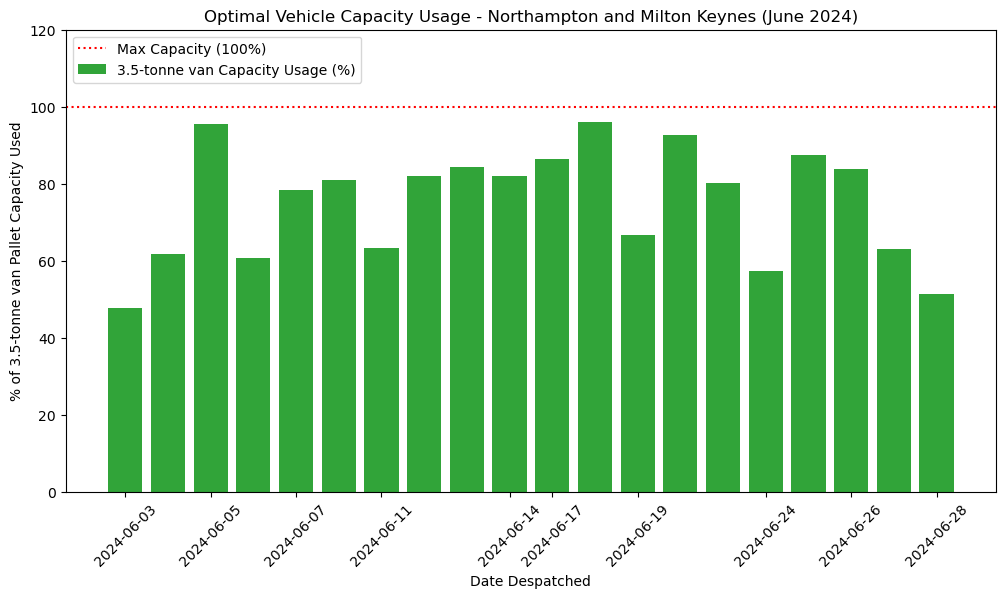

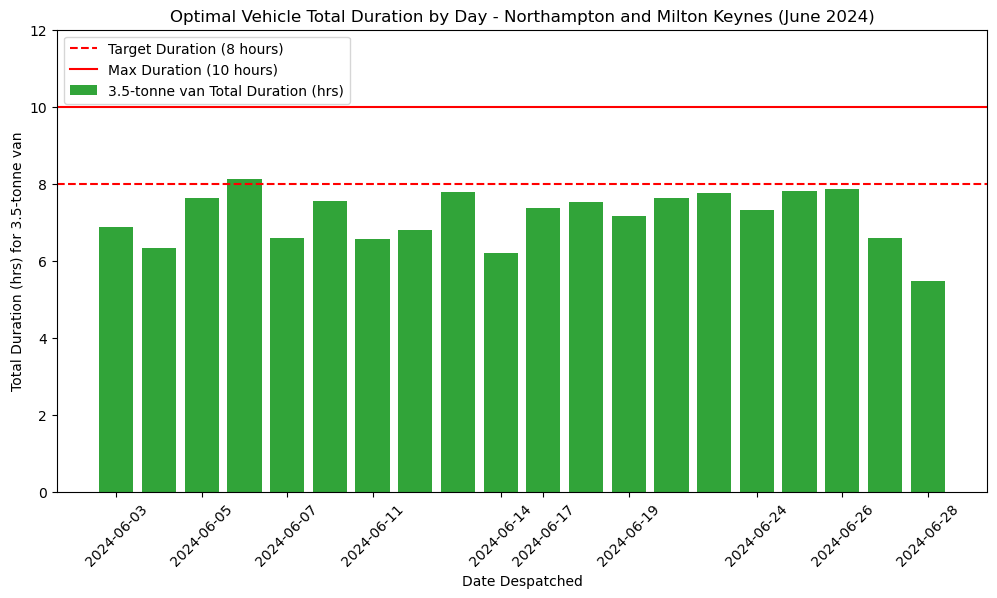

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the route summary CSV file generated previously
route_summary_df = pd.read_csv("50m_route_summary_cluster0,1_area3_max20_Summary.csv")

# 1% tolerance factor for capacity
tolerance_factor = 1.01

# Initialize cost and vehicle count tracking dictionaries
monthly_costs = {}
vehicle_usage = {}
usage_records = []  # For tracking usage per route for the time series plot
duration_records = []  # For tracking total duration per route for the time series plot

# Specify area names 
area_name_mapping = {
    0: "South Midlands and Cotswolds",
    1: "Greater Birmingham and Black Country",
    2: "Leicestershire and East Midlands",
    3: "Northampton and Milton Keynes"
}

area_number = 3  # Set this to the area number as per your data
area_name = area_name_mapping[area_number]

# Calculate the requirements based on each vehicle type
for vehicle_type, capacity in van_capacities.items():
    daily_vehicle_usage = []

    # Iterate through each day in the route summary
    for day, daily_routes in route_summary_df.groupby('date_despatched'):
        required_vehicles_for_day = 0  # Track required vehicles for each day

        for _, route in daily_routes.iterrows():
            # Get route requirements
            required_cubic_m = route['total_cubic_m']
            required_pallets = route['pallet_space']
            required_payload = route['line_weight_recalc'] / 1000  # Convert to tonnes

            # Calculate the number of vehicles required with 1% tolerance
            vehicles_for_cubic = np.ceil(required_cubic_m / (capacity['cubic'] * tolerance_factor))
            vehicles_for_pallets = np.ceil(required_pallets / (capacity['pallet_space'] * tolerance_factor))
            vehicles_for_payload = np.ceil(required_payload / (capacity['payload'] * tolerance_factor))

            # Take the maximum of the required vehicles to meet all constraints
            vehicles_needed = int(max(vehicles_for_cubic, vehicles_for_pallets, vehicles_for_payload))
            required_vehicles_for_day += vehicles_needed

            # Calculate pallet usage without dividing by the number of vehicles
            pallet_usage_percentage = (required_pallets / (capacity['pallet_space'] * vehicles_needed)) * 100
            pallet_usage_percentage = min(pallet_usage_percentage, 100)  # Cap usage at 100%

            # Track capacity usage per route for plotting
            usage_records.append({
                'date_despatched': route['date_despatched'],
                'cumulative_route_id': route['cumulative_route_id'],
                'vehicle_type': vehicle_type,
                'pallet_capacity_used_percent': pallet_usage_percentage
            })
            
            # Calculate and track total vehicle duration (in hours) per route for plotting
            vehicle_duration = route['total_duration_hr']  # Assuming 'total_duration_hr' is in hours
            duration_records.append({
                'date_despatched': route['date_despatched'],
                'vehicle_type': vehicle_type,
                'total_duration_hr': vehicle_duration
            })

        daily_vehicle_usage.append(required_vehicles_for_day)

    # Calculate maximum daily vehicles used and monthly costs
    max_vehicles_needed = max(daily_vehicle_usage)
    monthly_cost = max_vehicles_needed * van_costs_per_month[vehicle_type]

    # Store results for each vehicle type
    vehicle_usage[vehicle_type] = max_vehicles_needed
    monthly_costs[vehicle_type] = monthly_cost

# Calculate monthly metrics based on route summary data
total_delivery_cost = route_summary_df['delivery_cost'].sum()
total_revenue = route_summary_df['total_price'].sum()

# Determine the optimal vehicle configuration based on lowest monthly cost
optimal_vehicle_type = min(monthly_costs, key=monthly_costs.get)
optimal_vehicle_cost = monthly_costs[optimal_vehicle_type]
optimal_vehicle_usage = vehicle_usage[optimal_vehicle_type]

# Calculate cost-to-revenue percentages and savings
courier_cost_percentage = (total_delivery_cost / total_revenue) * 100 if total_revenue > 0 else 0
kite_cost_percentage = (optimal_vehicle_cost / total_revenue) * 100 if total_revenue > 0 else 0
delivery_cost_saving = total_delivery_cost - optimal_vehicle_cost

# Display results for each vehicle type
print("Monthly Vehicle Usage Summary (by vehicle type):")
for vehicle_type in vehicle_usage:
    print(f"{vehicle_type}: {vehicle_usage[vehicle_type]} vehicles used, Cost: £{monthly_costs[vehicle_type]:.2f}")

# Display optimal vehicle configuration with quantity
print("\nOptimal Vehicle Configuration:")
print(f"Vehicle Type: {optimal_vehicle_type}")
print(f"Vehicle Quantity Required: {optimal_vehicle_usage}")
print(f"Total Monthly Vehicle Cost: £{optimal_vehicle_cost:.2f}")

print("\nFinancial Summary:")
print(f"Total Monthly Delivery Cost (from routes): £{total_delivery_cost:.2f}")
print(f"Total Monthly Revenue Delivered: £{total_revenue:.2f}")

print("\nAdditional Metrics:")
print(f"% Cost : Revenue for Couriers: {courier_cost_percentage:.2f}%")
print(f"% Cost : Revenue for Kite: {kite_cost_percentage:.2f}%")
print(f"Total Delivery Cost Saving for Kite: £{delivery_cost_saving:.2f}")

# Filter to create a DataFrame of only the optimal vehicle's capacity usage
optimal_usage_df = pd.DataFrame([u for u in usage_records if u['vehicle_type'] == optimal_vehicle_type])

# Filter to create a DataFrame of only the optimal vehicle's total duration (in hours)
optimal_duration_df = pd.DataFrame([d for d in duration_records if d['vehicle_type'] == optimal_vehicle_type])

# Color for the bars
bar_color = '#31a439'

# Start plot setup for capacity usage
plt.figure(figsize=(12, 6))

# Plot capacity usage as green bars (with the specified color)
plt.bar(optimal_usage_df['date_despatched'], 
        optimal_usage_df['pallet_capacity_used_percent'], 
        color=bar_color, 
        label=f'{optimal_vehicle_type} Capacity Usage (%)')

# Add a dotted line at the 100% capacity level with tolerance
plt.axhline(100, color='red', linestyle='dotted', label='Max Capacity (100%)')

# Plot customization
plt.title(f"Optimal Vehicle Capacity Usage - {area_name} (June 2024)")
plt.xlabel("Date Despatched")
plt.ylabel(f"% of {optimal_vehicle_type} Pallet Capacity Used")
plt.ylim(0, 120)  # Ensure y-axis goes slightly above 100 to see the 100% line
plt.xticks(rotation=45, fontsize=10, ticks=optimal_usage_df['date_despatched'][::4])  # Display every 4th date

# Update legend with explanation of route numbers above bars
plt.legend(loc="upper left")
plt.grid(False)  # Disable gridlines
plt.show()

# Start plot setup for total vehicle duration by day
plt.figure(figsize=(12, 6))

# Plot total vehicle duration as green bars (with the specified color)
plt.bar(optimal_duration_df['date_despatched'], 
        optimal_duration_df['total_duration_hr'], 
        color=bar_color, 
        label=f'{optimal_vehicle_type} Total Duration (hrs)')

# Add a red dotted line for the 8-hour target and 10-hour max duration
plt.axhline(8, color='red', linestyle='--', label='Target Duration (8 hours)')
plt.axhline(10, color='red', linestyle='-', label='Max Duration (10 hours)')

# Plot customization
plt.title(f"Optimal Vehicle Total Duration by Day - {area_name} (June 2024)")
plt.xlabel("Date Despatched")
plt.ylabel(f"Total Duration (hrs) for {optimal_vehicle_type}")
plt.ylim(0, 12)  # Ensures the duration bars are well-spaced within the plot area
plt.xticks(rotation=45, fontsize=10, ticks=optimal_duration_df['date_despatched'][::4])  # Display every 4th date

# Update legend and remove gridlines
plt.legend(loc="upper left")
plt.grid(False)

# Display the plot
plt.show()

# Create the output DataFrame for the current area
output_data = {
    'area_name': [area_name],
    'vehicle_usage_summary': [str(vehicle_usage)],  # Store vehicle usage as a string for readability
    'optimal_vehicle_type': [optimal_vehicle_type],
    'optimal_vehicle_quantity': [optimal_vehicle_usage],
    'optimal_vehicle_cost': [optimal_vehicle_cost],
    'total_delivery_cost': [total_delivery_cost],
    'total_revenue': [total_revenue],
    'courier_cost_percentage': [courier_cost_percentage],
    'kite_cost_percentage': [kite_cost_percentage],
    'delivery_cost_saving': [delivery_cost_saving]
}

output_df = pd.DataFrame(output_data)

# Check if the CSV file exists
csv_file = '50mile_area_cost_summary_v2.csv'

# If the file does not exist, write the header, otherwise append without header
if not os.path.exists(csv_file):
    output_df.to_csv(csv_file, mode='w', header=True, index=False)
else:
    output_df.to_csv(csv_file, mode='a', header=False, index=False)
